In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from sys import path
#path.append('..')
#path.append("/Users/brandonbrown/miniforge3/lib/python3.9/site-packages")
from oasis.functions import gen_data, gen_sinusoidal_data, deconvolve, estimate_parameters
from oasis.plotting import simpleaxis
from oasis.oasis_methods import oasisAR1, oasisAR2
from IPython.display import display, update_display, clear_output
import time
import seaborn as sns
#
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold

from scipy import signal as sp_signal
from scipy.stats import norm
from scipy.signal import find_peaks
from sklearn.utils import resample
from joblib import Parallel, delayed
from scipy.stats import pearsonr
import scipy.stats as stats
from scipy.stats import mannwhitneyu
np.set_printoptions(suppress=True) #suppress scientific notation
import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\oasis\functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [2]:
def min_max_scale(arr, ref_arr):
    """
    Rescale an array to be on the same scale as a reference array using min-max scaling.

    Parameters:
        arr (numpy.ndarray): The array to be rescaled.
        ref_arr (numpy.ndarray): The reference array that defines the scaling range.

    Returns:
        numpy.ndarray: The rescaled array.
    """
    # Compute the min and max values of the reference array
    ref_min = ref_arr.min()
    ref_max = ref_arr.max()

    # Scale the values of the array to be between the min and max of the reference array
    scaled_arr = (arr - arr.min()) * (ref_max - ref_min) / (arr.max() - arr.min()) + ref_min

    return scaled_arr


In [3]:
def rescale_array(arr, new_min=0, new_max=1, axis=None):
    """
    Rescales a given NumPy array between two bounds along a specified axis.
    
    Parameters:
        arr (numpy.ndarray): Input array to be rescaled.
        new_min (float): Lower bound of the new range. Default is 0.
        new_max (float): Upper bound of the new range. Default is 1.
        axis (int): The axis along which to rescale the array. If None, the entire array is rescaled.
    
    Returns:
        numpy.ndarray: The rescaled array.
    """
    old_min, old_max = arr.min(axis=axis, keepdims=True), arr.max(axis=axis, keepdims=True)
    if np.all(old_max == old_min):
        # When the max and min are the same, return an array of new_min
        return np.full_like(arr, new_min)
    rescaled_arr = (new_max - new_min) * (arr - old_min) / (old_max - old_min) + new_min
    return rescaled_arr

def zscore_rescale_array(arr, axis=None):
    """
    Standardizes a given NumPy array using z-score normalization along a specified axis.
    
    Parameters:
        arr (numpy.ndarray): Input array to be standardized.
        axis (int): The axis along which to standardize the array. If None, the entire array is standardized.
    
    Returns:
        numpy.ndarray: The standardized array.
    """
    mean = np.mean(arr, axis=axis)
    std = np.std(arr, axis=axis)
    
    # Avoiding division by zero
    #std = np.where(std == 0, 1, std)
    
    zscored_arr = (arr - mean) / std
    return zscored_arr

In [4]:
import os
import pandas as pd
import numpy as np

def read_experiment_data(main_folder):
    # Initialize the main data dictionary with lists for each experimental condition
    data = {
        'calex': [],
        'ctrl': []
    }
    
    # Iterate through each subfolder in the main folder
    for folder_name in os.listdir(main_folder):
        folder_path = os.path.join(main_folder, folder_name)
        if os.path.isdir(folder_path):
            # Determine the condition from the folder name
            condition = 'calex' if 'CalEx' in folder_name else 'ctrl' if 'ctrl' in folder_name else None
            if condition:
                # Construct file paths for signal and behavior data
                signal_path = os.path.join(folder_path, "signal.csv")
                behavior_path = os.path.join(folder_path, "behavior.xlsx")
                
                if os.path.exists(signal_path) and os.path.exists(behavior_path):
                    signal = pd.read_csv(signal_path, skiprows=2, index_col=0, header=None).values
                    bx = pd.read_excel(behavior_path, engine='openpyxl', skiprows=1)
                    
                    # Append a dictionary with data to the list for the appropriate condition
                    data[condition].append({
                        'signal': signal,
                        'behavior': bx
                    })

    return data

### Load data

In [5]:
# Usage
main_data = read_experiment_data("CaMKII/")

In [6]:
print(len(main_data["calex"]),len(main_data["ctrl"]))

4 4


In [7]:
print(main_data["ctrl"][0]["signal"].shape)  # Access ctrl group, first animal, signal data

(6450, 19)


### Deconvolve all the signals for all the cells

##### Group-Specific Standardization

In [8]:
def within_animal_standardization(data):
    for group, animals in data.items():
        for animal in animals:
            individual_mean = np.mean(animal['signal'])
            individual_std = np.std(animal['signal'])

            # Standardizing signal
            if individual_std != 0:
                animal['standardized'] = (animal['signal'] - individual_mean) / individual_std
            else:
                animal['standardized'] = animal['signal'] - individual_mean
within_animal_standardization(main_data)

Text(0.5, 1.0, 'Group-Standardized Signal')

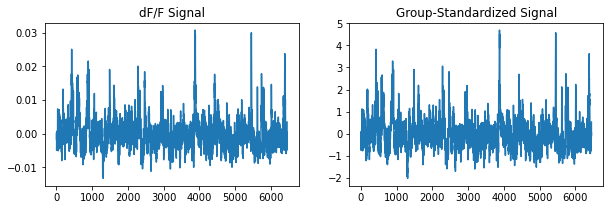

In [9]:
# Plot an example neuron trace, dF/F and denoised version
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,3)
ax[0].plot(main_data["ctrl"][0]["signal"][:,15])
ax[0].set_title("dF/F Signal")
ax[1].plot(main_data["ctrl"][0]["standardized"][:,15])
ax[1].set_title("Group-Standardized Signal")

In [10]:
%%time
def process_signal_data(data):
    """Process signal data for all animals in both experimental groups to denoise and deconvolve calcium signals."""
    for condition in data.keys():
        for animal in data[condition]:
            signal = animal['signal']
            y = np.zeros(signal.shape)  # discretized
            sm = np.zeros(signal.shape)  # denoised
            for i in range(signal.shape[1]):
                x1 = signal[:, i]
                #x1 += np.abs(x1.min())  # make all positive
                #x1 = zscore_rescale_array(x1)
                c, s, _, _, _ = deconvolve(x1, g=(None,), penalty=1)
                # c is denoised, s is deconv
                #s = rescale_array(s)  # re-scale to be in [0,1]
                s[s < (2.0 * s.std())] = 0  # eliminate low amplitude events
                y[:, i] = s[:]
                sm[:, i] = c[:]
            animal['denoised'] = sm
            animal['deconv'] = y

# Example usage
process_signal_data(main_data)
print(main_data["ctrl"][0]["denoised"])  # Access denoised data for the first ctrl animal
print(main_data["ctrl"][0]["deconv"])    # Access deconvolved data for the first ctrl animal

[[0.         0.06194892 0.         ... 0.         0.00262489 0.        ]
 [0.         0.06344781 0.         ... 0.         0.00251451 0.        ]
 [0.         0.06428532 0.         ... 0.         0.00240876 0.        ]
 ...
 [0.00000159 0.00034284 0.00000398 ... 0.01271495 0.00622988 0.01066556]
 [0.00000153 0.00033448 0.0000037  ... 0.0124102  0.00596789 0.01221999]
 [0.00000147 0.00032633 0.00000344 ... 0.01187345 0.00737741 0.0117352 ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00300976 0.         ... 0.         0.         0.        ]
 [0.         0.00238493 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00314939 0.00320205 0.0011242 ]
 [0.         0.         0.         ... 0.         0.         0.00197755]
 [0.         0.         0.         ... 0.         0.00166049 0.        ]]
Wall time: 15.3 s


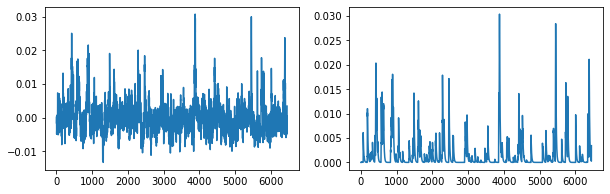

In [11]:
# Plot an example neuron trace, dF/F and denoised version
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,3)
ax[0].plot(main_data["ctrl"][0]["signal"][:,15])
ax[1].plot(main_data["ctrl"][0]["denoised"][:,15])

In [12]:
def gen_bx_arr(bx: pd.DataFrame, total_frames):
    y = np.zeros(total_frames)
    bx_dict = {
        "Undefined": -1,
        "Open": 1,
        "Closed": 2
    }
    
    for i in range(len(bx)):
        start_frame = int(bx.iloc[i, 1]) - 1
        end_frame = int(bx.iloc[i, 2]) - 1
        behavior = bx.iloc[i, 0].capitalize()

        # Ensure end_frame does not exceed total_frames
        end_frame = min(end_frame, total_frames - 1)

        # Label the frames for the behavior
        for frame in range(start_frame, end_frame + 1):
            if bx_dict[behavior] == -1 and frame != start_frame:  # Handle 'Undefined' category differently
                y[frame] = -1
            elif y[frame] == 0:  # If not already labeled, label it
                y[frame] = bx_dict[behavior]
    
    return y

In [13]:
def process_behavior_labels(data):
    """Apply the gen_bx_arr function across all animals in each group and add 'bx_labels' to their dictionaries."""
    for condition in data.keys():  # Iterate over each experimental condition
        for animal in data[condition]:  # Iterate over each animal in the condition
            total_frames = animal['signal'].shape[0]  # Determine the number of time frames from the signal data
            labels = gen_bx_arr(animal['behavior'], total_frames=total_frames)  # Generate behavior labels
            animal['bx_labels'] = labels  # Store the generated labels in the animal's dictionary

process_behavior_labels(main_data)  # Process behavior labels for all animals

In [14]:
# Access behavior labels for the first ctrl animal
print(main_data["ctrl"][1]["bx_labels"])

[-1. -1. -1. ... -1. -1. -1.]


##### Remove undefined time periods

In [15]:
def remove_unknown_times(main_data):
    for group, animals in main_data.items():
        for animal in animals:
            signal = animal['denoised']  # Time x Neuron matrix
            labels = animal['bx_labels']  # Behavior labels

            # Filter out the rows where behavior is unidentified
            valid_indices = labels != -1
            filtered_signal = signal[valid_indices, :]
            filtered_labels = labels[valid_indices]

            # Store filtered data back into main_data for analysis
            animal['filt_denoised'] = filtered_signal
            animal['filt_labels'] = filtered_labels

In [16]:
remove_unknown_times(main_data)

In [17]:
np.unique(main_data["ctrl"][1]["filt_labels"])

array([1., 2.])

In [18]:
def calculate_open_arm_proportions(data):
    # Iterate over each group and each animal
    for group in ['calex', 'ctrl']:
        for animal in data[group]:
            bx_labels = animal['filt_labels']
            if bx_labels is not None:
                # Calculate the proportion of time spent in the open arm
                proportion_open = np.sum(bx_labels == 1) / len(bx_labels)
                if 'analysis' not in animal:
                    animal['analysis'] = {}
                animal['analysis']['proportion_open_arm'] = proportion_open

# Example usage assuming main_data is properly structured
calculate_open_arm_proportions(main_data)


In [19]:
main_data['calex'][0]['analysis']['proportion_open_arm']

0.1635

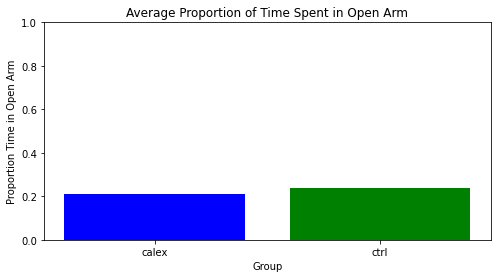

Proportions of Time Spent in Open Arm: {'calex': 0.21248997083214316, 'ctrl': 0.23908988929680508}


In [20]:
def plot_open_arm_proportions(data):
    # Dictionary to hold average open arm times for each group
    open_arm_proportions = {}

    # Iterate over each group (calex and ctrl)
    for group in ['calex', 'ctrl']:
        proportions = []
        
        # Loop through each animal in the group
        for animal in data[group]:
            if 'analysis' in animal and 'proportion_open_arm' in animal['analysis']:
                proportions.append(animal['analysis']['proportion_open_arm'])
        
        # Calculate the average proportion for the group
        if proportions:
            open_arm_proportions[group] = np.mean(proportions)
        else:
            open_arm_proportions[group] = 0  # Default to 0 if no data available
    
    # Plotting the results
    groups = list(open_arm_proportions.keys())
    proportions = list(open_arm_proportions.values())
    
    plt.figure(figsize=(8, 4))
    plt.bar(groups, proportions, color=['blue', 'green'])
    plt.xlabel('Group')
    plt.ylabel('Proportion Time in Open Arm')
    plt.title('Average Proportion of Time Spent in Open Arm')
    plt.ylim(0, 1)  # Since proportions range from 0 to 1
    plt.show()

    return open_arm_proportions

# Call the plotting function
open_arm_proportions = plot_open_arm_proportions(main_data)
print("Proportions of Time Spent in Open Arm:", open_arm_proportions)

In [21]:
def calculate_open_arm_entries(data):
    for group in ['calex', 'ctrl']:
        for animal in data[group]:
            bx_labels = animal['filt_labels']
            if bx_labels is not None:
                # Calculate the number of times entered the open arm
                num_entries = np.sum(np.diff(bx_labels == 1) == 1)
                if 'analysis' not in animal:
                    animal['analysis'] = {}
                animal['analysis']['open_arm_entries'] = num_entries

# Assuming main_data is structured and available
calculate_open_arm_entries(main_data)


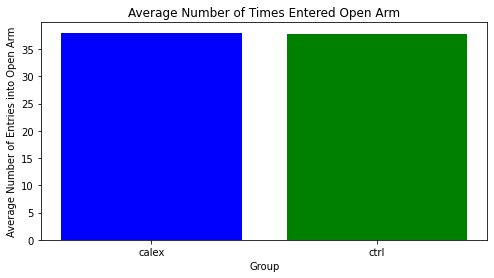

Average Number of Entries into Open Arm: {'calex': 38.0, 'ctrl': 37.75}


In [22]:
def plot_open_arm_entries(data):
    open_arm_entries = {}

    for group in ['calex', 'ctrl']:
        entries = []

        for animal in data[group]:
            if 'analysis' in animal and 'open_arm_entries' in animal['analysis']:
                entries.append(animal['analysis']['open_arm_entries'])

        if entries:
            open_arm_entries[group] = np.mean(entries)
        else:
            open_arm_entries[group] = 0  # Default to 0 if no data available

    # Plotting the results
    groups = list(open_arm_entries.keys())
    entries = list(open_arm_entries.values())
    
    plt.figure(figsize=(8, 4))
    plt.bar(groups, entries, color=['blue', 'green'])
    plt.xlabel('Group')
    plt.ylabel('Average Number of Entries into Open Arm')
    plt.title('Average Number of Times Entered Open Arm')
    plt.show()

    return open_arm_entries

# Call the plotting function with the updated main_data
open_arm_entries = plot_open_arm_entries(main_data)
print("Average Number of Entries into Open Arm:", open_arm_entries)

In [23]:
from scipy import stats

def perform_statistical_test(main_data):
    # Retrieve the lists of entries for each group from main_data
    calex_entries = [animal['analysis']['open_arm_entries'] for animal in main_data['calex'] if 'analysis' in animal and 'open_arm_entries' in animal['analysis']]
    ctrl_entries = [animal['analysis']['open_arm_entries'] for animal in main_data['ctrl'] if 'analysis' in animal and 'open_arm_entries' in animal['analysis']]

    # Perform the Mann-Whitney U Test
    u_statistic, p_value = stats.mannwhitneyu(calex_entries, ctrl_entries, alternative='two-sided')

    # Print the results
    print(f'U-statistic: {u_statistic}')
    print(f'P-value: {p_value}')

    # Interpret the results
    if p_value < 0.05:
        print("There is a statistically significant difference between the distributions of open arm entries between calex and ctrl groups.")
    else:
        print("There is no statistically significant difference between the distributions of open arm entries between calex and ctrl groups.")

# Assuming main_data is properly structured and the analysis has been performed
perform_statistical_test(main_data)


U-statistic: 7.0
P-value: 0.8857142857142857
There is no statistically significant difference between the distributions of open arm entries between calex and ctrl groups.


# Analyze Mean Signal Across Groups and Conditions

In [24]:
def compute_mean_signal(main_data):
    for group, animals in main_data.items():
        for animal in animals:
            data_deconv = rescale_array(animal['deconv'])
            data_denoised = rescale_array(animal['filt_denoised'])
            mean_deconv = np.mean(data_deconv, axis=0)  # Calculating mean across time for each neuron
            mean_denoised = np.mean(data_denoised, axis=0)
            # Ensuring the 'analysis' key exists and adding 'mean_deconv'
            if 'analysis' not in animal:
                animal['analysis'] = {}
            animal['analysis']['mean_deconv'] = mean_deconv
            animal['analysis']['mean_denoised'] = mean_denoised

# Example usage, assuming your 'main_data' is properly structured
compute_mean_signal(main_data)


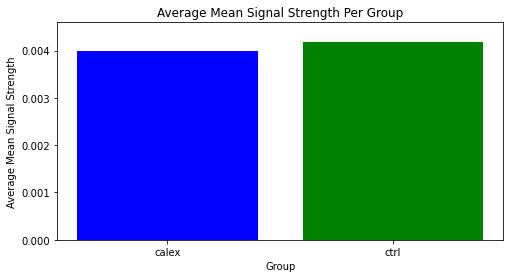

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def plot_group_level_mean_signals(main_data):
    # Calculate mean signals for each group
    group_averages = {}

    for group, animals in main_data.items():
        all_signals = []
        for animal in animals:
            if 'analysis' in animal and 'mean_denoised' in animal['analysis']:
                all_signals.extend(animal['analysis']['mean_deconv'])
        
        # Calculate the average of all mean signals in the group
        if all_signals:
            group_averages[group] = np.mean(all_signals)
        else:
            group_averages[group] = 0  # Default to 0 if no data available

    # Plotting
    groups = list(group_averages.keys())
    averages = list(group_averages.values())
    
    plt.figure(figsize=(8, 4))
    plt.bar(groups, averages, color=['blue', 'green'])
    plt.xlabel('Group')
    plt.ylabel('Average Mean Signal Strength')
    plt.title('Average Mean Signal Strength Per Group')
    plt.ylim(0, max(averages) * 1.1)  # Extend y-limit slightly above max for visual comfort
    plt.show()

# Example usage
plot_group_level_mean_signals(main_data)


### Run Statistics on Calex vs Ctrl Mean Signals

In [26]:
from scipy.stats import mannwhitneyu

def test_mean_signal_differences(main_data):
    # Prepare data for statistical testing
    group_signals = {'calex': [], 'ctrl': []}
    
    for group, animals in main_data.items():
        for animal in animals:
            if 'analysis' in animal and 'mean_deconv' in animal['analysis']:
                group_signals[group].extend(animal['analysis']['mean_deconv'])
    
    # Extract the lists of signals
    calex_signals = group_signals['calex']
    ctrl_signals = group_signals['ctrl']
    
    # Ensure that there is data to compare
    if calex_signals and ctrl_signals:
        # Perform the Mann-Whitney U test
        stat, p_value = mannwhitneyu(calex_signals, ctrl_signals, alternative='two-sided')
        print("Mann-Whitney U test result:")
        print(f"U-statistic: {stat}, P-value: {p_value}")
        if p_value < 0.05:
            print("There is a statistically significant difference between the groups.")
        else:
            print("There is no statistically significant difference between the groups.")
    else:
        print("Insufficient data in one of the groups for statistical testing.")

# Example usage
test_mean_signal_differences(main_data)


Mann-Whitney U test result:
U-statistic: 149538.0, P-value: 0.6761215550421154
There is no statistically significant difference between the groups.


#### Save Mean Signal Data to Excel

Uncomment last line.

In [27]:
import pandas as pd

def export_mean_signals_to_excel(main_data, file_name="Mean_Signal_Strengths.xlsx"):
    # Prepare data for DataFrame
    data_to_export = []
    
    for group, animals in main_data.items():
        for animal_index, animal in enumerate(animals):
            if 'analysis' in animal and 'mean_deconv' in animal['analysis']:
                mean_signals = animal['analysis']['mean_deconv']
                for neuron_id, mean_signal in enumerate(mean_signals):
                    data_to_export.append({
                        'Group': group,
                        'Animal': f"Animal {animal_index + 1}",
                        'Neuron_ID': neuron_id + 1,
                        'Mean_Signal': mean_signal
                    })
    
    # Create DataFrame
    df = pd.DataFrame(data_to_export)
    
    # Export to Excel
    df.to_excel(file_name, index=False)
    print(f"Data exported to {file_name}")

# Example usage
#export_mean_signals_to_excel(main_data)

### Calculate Signal Averages by Condition (Open vs Closed)

In [28]:
def calculate_neuron_wise_average_denoised_signal(data):
    for group, animals in data.items():
        for animal in animals:
            denoised_signal = animal['denoised']
            bx_labels = animal['bx_labels']
            
            if 'analysis' not in animal:
                animal['analysis'] = {'open_avg_per_neuron': [], 'closed_avg_per_neuron': []}
            
            # Process for behavior 1 OPEN
            mask_open = (bx_labels == 1)
            if np.any(mask_open):
                open_avg_per_neuron = np.mean(denoised_signal[mask_open, :], axis=0)
                animal['analysis']['open_avg_per_neuron'] = open_avg_per_neuron
            else:
                animal['analysis']['open_avg_per_neuron'] = np.array([])  # No open data available
            
            # Process for behavior 2 CLOSED
            mask_closed = (bx_labels == 2)
            if np.any(mask_closed):
                closed_avg_per_neuron = np.mean(denoised_signal[mask_closed, :], axis=0)
                animal['analysis']['closed_avg_per_neuron'] = closed_avg_per_neuron
            else:
                animal['analysis']['closed_avg_per_neuron'] = np.array([])  # No closed data available

# Assuming main_data is properly structured and filled
calculate_neuron_wise_average_denoised_signal(main_data)

In [29]:
#main_data['calex'][1]['analysis']['closed_avg_per_neuron'].shape

In [30]:
from scipy.stats import mannwhitneyu

def test_neuron_wise_activity_differences(data):
    calex_open = [value for animal in data['calex'] for value in animal['analysis']['open_avg_per_neuron']]
    calex_closed = [value for animal in data['calex'] for value in animal['analysis']['closed_avg_per_neuron']]
    ctrl_open = [value for animal in data['ctrl'] for value in animal['analysis']['open_avg_per_neuron']]
    ctrl_closed = [value for animal in data['ctrl'] for value in animal['analysis']['closed_avg_per_neuron']]

    # Testing open averages
    u_stat_open, p_val_open = mannwhitneyu(calex_open, ctrl_open, alternative='two-sided')
    print(f'Open Arms - U-statistic: {u_stat_open}, P-value: {p_val_open}')

    # Testing closed averages
    u_stat_closed, p_val_closed = mannwhitneyu(calex_closed, ctrl_closed, alternative='two-sided')
    print(f'Closed Arms - U-statistic: {u_stat_closed}, P-value: {p_val_closed}')

    return {
        'open': {'u_stat': u_stat_open, 'p_val': p_val_open},
        'closed': {'u_stat': u_stat_closed, 'p_val': p_val_closed}
    }

# Run statistical tests
results = test_neuron_wise_activity_differences(main_data)

Open Arms - U-statistic: 115845.0, P-value: 1.1810778435549868e-11
Closed Arms - U-statistic: 117965.0, P-value: 1.7475488349385678e-10


In [31]:
def test_intra_group_activity_differences(data):
    # Gather the data
    calex_open = [value for animal in data['calex'] for value in animal['analysis']['open_avg_per_neuron']]
    calex_closed = [value for animal in data['calex'] for value in animal['analysis']['closed_avg_per_neuron']]
    ctrl_open = [value for animal in data['ctrl'] for value in animal['analysis']['open_avg_per_neuron']]
    ctrl_closed = [value for animal in data['ctrl'] for value in animal['analysis']['closed_avg_per_neuron']]

    # Testing within groups: Calex Open vs Closed
    u_stat_calex, p_val_calex = mannwhitneyu(calex_open, calex_closed, alternative='two-sided')
    print(f'Calex - Open vs Closed - U-statistic: {u_stat_calex}, P-value: {p_val_calex}')

    # Testing within groups: Ctrl Open vs Closed
    u_stat_ctrl, p_val_ctrl = mannwhitneyu(ctrl_open, ctrl_closed, alternative='two-sided')
    print(f'Ctrl - Open vs Closed - U-statistic: {u_stat_ctrl}, P-value: {p_val_ctrl}')

    return {
        'calex': {'u_stat': u_stat_calex, 'p_val': p_val_calex},
        'ctrl': {'u_stat': u_stat_ctrl, 'p_val': p_val_ctrl}
    }

# Run statistical tests
intra_group_results = test_intra_group_activity_differences(main_data)


Calex - Open vs Closed - U-statistic: 114953.0, P-value: 0.02780844492277713
Ctrl - Open vs Closed - U-statistic: 180317.0, P-value: 0.5223859936343495


In [32]:
def detect_spikes(signal, height=None, distance=None, prominence=None, width=None):
    if height is None:
        height = 0.1 * np.max(signal)  # Adjusted based on your data characteristics
    if distance is None:
        distance = 0.01 * len(signal)  # Approx 1% of the data points
    if prominence is None:
        prominence = 0.1 * (np.max(signal) - np.min(signal))
    
    indices, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence, width=width)
    return indices

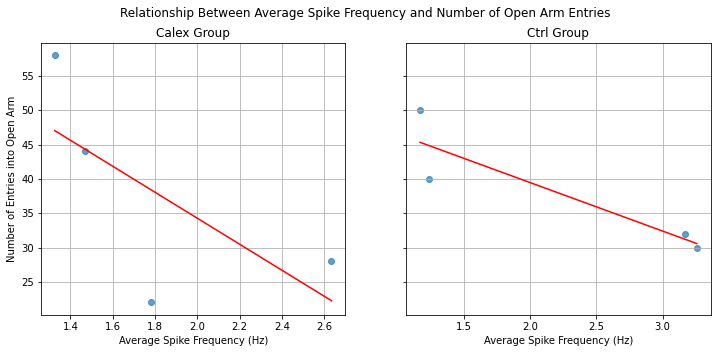

In [33]:
def calculate_spike_frequency(spikes, total_time):
    return len(spikes) / total_time

def analyze_spike_frequency_with_behavior(data):
    results = {'calex': [], 'ctrl': []}
    entry_count_results = {'calex': [], 'ctrl': []}  # To store the number of entries into the open arm
    
    for group, animals in data.items():
        for animal in animals:
            signal_matrix = animal['denoised']  # Assuming this is a Time x Neurons matrix
            labels = animal['bx_labels']  # Behavioral labels
            
            # Calculate number of entries into the open arm
            entries = np.sum(np.diff(labels == 1) == 1)
            
            total_time = signal_matrix.shape[0] / 1000  # Assuming 1000 Hz sampling rate
            avg_spike_freqs = []
            
            # Compute spike frequency for each neuron
            for neuron in range(signal_matrix.shape[1]):
                spikes = detect_spikes(signal_matrix[:, neuron])
                spike_freq = calculate_spike_frequency(spikes, total_time)
                avg_spike_freqs.append(spike_freq)
            
            # Average spike frequency across all neurons
            avg_spike_freq = np.mean(avg_spike_freqs) if avg_spike_freqs else 0
            
            results[group].append(avg_spike_freq)
            entry_count_results[group].append(entries)
    
    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    for i, group in enumerate(['calex', 'ctrl']):
        ax[i].scatter(results[group], entry_count_results[group], alpha=0.7)
        ax[i].set_title(f'{group.capitalize()} Group')
        ax[i].set_xlabel('Average Spike Frequency (Hz)')
        
        # Fit and plot a linear model
        if len(results[group]) > 1:  # Ensure there are enough data points to fit a model
            z = np.polyfit(results[group], entry_count_results[group], 1)
            p = np.poly1d(z)
            xp = np.linspace(min(results[group]), max(results[group]), 100)
            ax[i].plot(xp, p(xp), color="red")  # Plotting the best-fit line
        
        ax[i].grid(True)
    
    ax[0].set_ylabel('Number of Entries into Open Arm')
    plt.suptitle('Relationship Between Average Spike Frequency and Number of Open Arm Entries')
    plt.show()
    
    return results, entry_count_results

# Example usage assuming main_data is already loaded and processed
spike_freq_results, entry_count_results = analyze_spike_frequency_with_behavior(main_data)


In [34]:
import numpy as np
from scipy.signal import find_peaks

def detect_spikes(signal, height=None, distance=None, prominence=None, width=None):
    if height is None:
        height = 0.1 * np.max(signal)  # Adjusted based on your data characteristics
    if distance is None:
        distance = 0.01 * len(signal)  # Approx 1% of the data points
    if prominence is None:
        prominence = 0.1 * (np.max(signal) - np.min(signal))
    
    indices, properties = find_peaks(signal, height=height, distance=distance, prominence=prominence, width=width)
    return indices, properties['peak_heights']


### Compute AUC and p-values for each neuron

In [35]:
import numpy as np
from joblib import Parallel, delayed
from sklearn.metrics import roc_auc_score

def compute_auc_and_p_values_worker(neuron_trace, binary_label_vectors, label_indices, n_permutations, rng):
    results = []
    for label, binary_label_vector in binary_label_vectors.items():
        auc = roc_auc_score(binary_label_vector, neuron_trace)

        # Permutation test for p-values
        shuffled_auc_values = np.zeros(n_permutations)
        for i in range(n_permutations):
            shift = rng[i]  # Use pre-generated random shift
            shuffled_labels = np.roll(binary_label_vector, shift)
            shuffled_auc = roc_auc_score(shuffled_labels, neuron_trace)
            shuffled_auc_values[i] = shuffled_auc

        p_value = 2 * min(
            np.sum(auc >= shuffled_auc_values) / n_permutations,
            np.sum(auc <= shuffled_auc_values) / n_permutations
        )

        results.append((label_indices[label], auc, p_value))
    return results

def process_all_animals(data, n_permutations=1000):
    for group, animals in data.items():
        for animal in animals:
            signal = animal['filt_denoised']
            labels = animal['filt_labels']
            unique_labels = np.unique(labels)
            n_neurons = signal.shape[1]
            n_labels = len(unique_labels)

            auc_matrix = np.zeros((n_neurons, n_labels))
            p_values_matrix = np.zeros((n_neurons, n_labels))

            # Pre-compute binary label vectors for each unique label
            binary_label_vectors = {label: (labels == label).astype(int) for label in unique_labels}
            label_indices = {label: i for i, label in enumerate(unique_labels)}

            # Pre-generate random shifts
            rng = np.random.default_rng()
            #Prevent wrap around:
            random_shifts = rng.integers(1800, len(labels) - 1800, size=n_permutations)

            # Parallel processing
            results = Parallel(n_jobs=-1)(
                delayed(compute_auc_and_p_values_worker)(
                    signal[:, neuron], binary_label_vectors, label_indices, n_permutations, random_shifts
                ) for neuron in range(n_neurons)
            )

            # Organize results into matrices
            for neuron, neuron_results in enumerate(results):
                for label_idx, auc, p_value in neuron_results:
                    auc_matrix[neuron, label_idx] = auc
                    p_values_matrix[neuron, label_idx] = p_value

            animal['auc_matrix'] = auc_matrix
            animal['p_values_matrix'] = p_values_matrix

In [36]:
%%time
# Example usage with your main_data
process_all_animals(main_data, n_permutations=1000) # Should be at least 500

Wall time: 8min 32s


In [37]:
#print(auc_matrix)
#print(p_values_matrix)
#print(signal.describe(

In [38]:
def summarize_tuning(data):
    for group, animals in data.items():
        for animal in animals:
            auc_matrix = animal['auc_matrix']
            p_values_matrix = animal['p_values_matrix']
            n_neurons, n_behaviors = auc_matrix.shape

            # Calculate Bonferroni correction threshold
            alpha = 0.05 / (n_neurons * n_behaviors)

            # Create DataFrame
            df = pd.DataFrame({
                "Neuron": np.arange(n_neurons),
                "AUC 1": auc_matrix[:, 0],
                "pvalue 1": p_values_matrix[:, 0],
                "AUC 2": auc_matrix[:, 1],
                "pvalue 2": p_values_matrix[:, 1]
            })

            # Determine the tuning of each neuron
            significant_1 = (df['pvalue 1'] < alpha) & (df['AUC 1'] > df['AUC 2'])
            significant_2 = (df['pvalue 2'] < alpha) & (df['AUC 2'] > df['AUC 1'])

            # Assign positions
            df['Position'] = -2  # Default unassigned
            df.loc[significant_1, 'Position'] = 1  # Tuned to behavior 1
            df.loc[significant_2, 'Position'] = 2  # Tuned to behavior 2

            # If a neuron is significant for both, it's possible due to high AUC in both but check which is higher
            dual_significant = significant_1 & significant_2
            df.loc[dual_significant, 'Position'] = df.loc[dual_significant, ['AUC 1', 'AUC 2']].idxmax(axis=1).apply(lambda x: int(x.split(' ')[1]) - 1)

            # Store the results back in the main_data
            animal['tuning_summary'] = df

# Assuming main_data is structured correctly, you can call this function
# summarize_tuning(main_data)


In [39]:
# Example usage with your main_data
summarize_tuning(main_data)

In [40]:
main_data['calex'][0]['tuning_summary'].tail()

,Neuron,AUC 1,pvalue 1,AUC 2,pvalue 2,Position
53,53,0.472445,0.878,0.527555,0.878,-2.0
54,54,0.391170,0.010,0.608830,0.010,-2.0
55,55,0.496334,0.934,0.503666,0.934,-2.0
56,56,0.390694,0.050,0.609306,0.050,-2.0
57,57,0.715839,0.000,0.284161,0.000,1.0


#### Save tuning summary data to excel

Uncomment the last line of code.

In [41]:
import pandas as pd

def save_combined_tuning_summary(main_data, output_file="tuning_summaries.xlsx"):
    # Prepare a DataFrame to collect all the data
    combined_data = {
        'Group': [],
        'Animal': [],
        'Neuron_ID': [],
        'AUC_1': [],
        'pvalue_1': [],
        'AUC_2': [],
        'pvalue_2': [],
        'Position': []
    }

    for group in main_data.keys():
        for i, animal in enumerate(main_data[group]):
            tuning_summary = animal['tuning_summary']
            neuron_count = len(tuning_summary)
            combined_data['Group'].extend([group] * neuron_count)
            combined_data['Animal'].extend([f"Animal {i+1}"] * neuron_count)
            combined_data['Neuron_ID'].extend(tuning_summary.index.tolist())
            combined_data['AUC_1'].extend(tuning_summary['AUC 1'])
            combined_data['pvalue_1'].extend(tuning_summary['pvalue 1'])
            combined_data['AUC_2'].extend(tuning_summary['AUC 2'])
            combined_data['pvalue_2'].extend(tuning_summary['pvalue 2'])
            combined_data['Position'].extend(tuning_summary['Position'])

    # Create a DataFrame from the collected data
    df = pd.DataFrame(combined_data)

    # Save the DataFrame to an Excel file
    with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
        df.to_excel(writer, index=False)

    print(f"Saved combined tuning summary to {output_file}")

# Call the function to save the data
#save_combined_tuning_summary(main_data)


### Plot proportions of tuned cells for each group

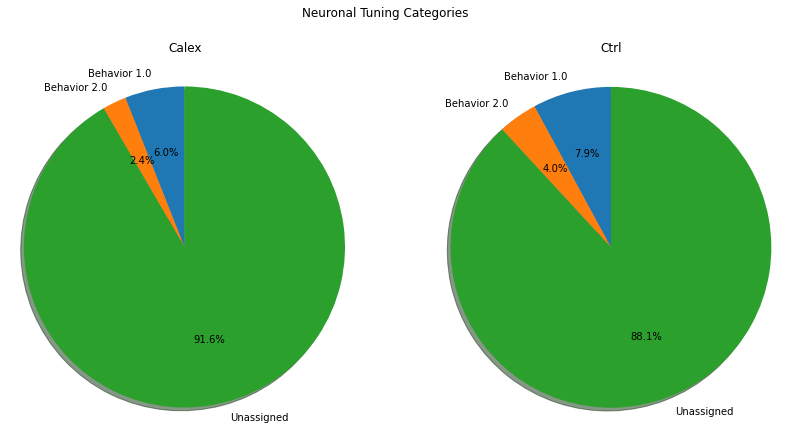

In [42]:
import matplotlib.pyplot as plt

def plot_tuning_pie_charts(main_data):
    tuning_counts = {'calex': {}, 'ctrl': {}}

    # Aggregate tuning information for each group
    for group, animals in main_data.items():
        all_positions = []
        for animal in animals:
            if 'tuning_summary' in animal:
                # Collect all position data for current animal
                all_positions.extend(animal['tuning_summary']['Position'].tolist())

        # Count occurrences of each position category
        categories = set(all_positions)
        for category in categories:
            tuning_counts[group][category] = all_positions.count(category)

    # Plotting the pie charts for each group
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    fig.suptitle('Neuronal Tuning Categories')

    for i, (group, counts) in enumerate(tuning_counts.items()):
        labels = ['Behavior ' + str(k) if k >= 0 else 'Mixed' if k == -1 else 'Unassigned' for k in counts.keys()]
        sizes = list(counts.values())
        axs[i].pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
        axs[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        axs[i].set_title(group.capitalize())

    plt.show()

# Example usage with your main_data after 'tuning_summary' has been added
plot_tuning_pie_charts(main_data)


In [43]:
def detect_spikes(signal, height=None):
    if height is None:
        height = 0.1 * np.max(signal)
    indices, _ = find_peaks(signal, height=height)
    return indices

def compute_synchrony(matrix):
    if np.any(np.isnan(matrix)):
        print("NaN found in input matrix for synchrony calculation.")
    if matrix.size == 0:
        print("Empty matrix passed to synchrony calculation.")
        return np.nan
    corr_matrix = np.corrcoef(matrix.T)
    return np.nanmean(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])

def extract_neural_data(data, start, end):
    if start < 0 or end > data.shape[0]:
        print(f"Attempted to extract data with start={start}, end={end} out of bounds.")
        return np.array([])
    return data[start:end, :]

# Neural Metrics for Transition vs Non-Transition

In [44]:
def analyze_neural_activity(data, group, segment_length, sampling_rate, neuron_type='all', buffer=2):
    for animal in data[group]:
        signal = animal['filt_denoised']  # Denoised signal data
        deconv_signal = animal['deconv']  # Deconvolved calcium signal
        labels = animal['filt_labels']
        tuning_summary = animal['tuning_summary']

        # Ensure the 'analysis' dictionary exists
        if 'analysis' not in animal:
            animal['analysis'] = {}
        
        # Initialize 'neural_analysis' under 'analysis' if not already present
        if 'neural_analysis' not in animal['analysis']:
            animal['analysis']['neural_analysis'] = {}
        
        animal['analysis']['neural_analysis'][neuron_type] = {'transition': [], 'non_transition': []}


        # Define neuron indices based on type
        neuron_indices = get_neuron_indices(neuron_type, tuning_summary)
        if len(neuron_indices) == 0:
            continue
        # Extract closed intervals longer than 2*segment_length
        closed_indices = np.where(labels == 2)[0]
        if len(closed_indices) == 0:
            continue
        split_points = np.where(np.diff(closed_indices) != 1)[0] + 1
        closed_intervals = np.split(closed_indices, split_points)
        valid_intervals = [interval for interval in closed_intervals if len(interval) > 2 * segment_length * sampling_rate]
        total_intervals = len(valid_intervals)
        for i, interval in enumerate(valid_intervals):
            start_idx = interval[0] + buffer * sampling_rate
            end_idx = interval[-1] - (5*segment_length * sampling_rate + buffer * sampling_rate)
            # Extract non-transition segments
            non_trans_start = start_idx
            while (non_trans_start + segment_length * sampling_rate) <= end_idx:
                non_trans_end = non_trans_start + segment_length * sampling_rate
                deconv_segment = deconv_signal[non_trans_start:non_trans_end, neuron_indices]
                segment = signal[non_trans_start:non_trans_end, neuron_indices]
                compute_and_store_features(animal, neuron_type, "non_transition", segment, deconv_segment)
                #
                non_trans_start += segment_length * sampling_rate
            #print(len(interval), i)
                
            # Extract transition segment
            #if i < (total_intervals - 1):
            if interval[-1] < (len(labels) - 1):
                trans_start = interval[-1] - (segment_length * sampling_rate)
                trans_end = interval[-1]
                deconv_segment = deconv_signal[trans_start:trans_end, neuron_indices]
                segment = signal[trans_start:trans_end, neuron_indices]
                compute_and_store_features(animal, neuron_type, "transition", segment, deconv_segment)
            
def get_neuron_indices(neuron_type, tuning_summary):
    if neuron_type == 'all':
        return np.arange(tuning_summary.shape[0])
    return tuning_summary[tuning_summary['Position'] == {'open': 1, 'closed': 2, 'unassigned': -2}[neuron_type]]['Neuron'].values

def compute_and_store_features(animal, neuron_type, event_type, segment, deconv_segment):
    animal['analysis']['neural_analysis'][neuron_type][event_type].append({
        'synchrony': compute_synchrony(segment),
        'amplitude': np.nanmean(segment),
        'deconv_mean': np.nanmean(deconv_segment)
    })

In [45]:
# Example call, assuming main_data is structured properly
time_window = 1
sampling_rate = 15
analyze_neural_activity(main_data, 'calex', time_window, sampling_rate, 'open')  
analyze_neural_activity(main_data, 'ctrl', time_window, sampling_rate, 'open')
analyze_neural_activity(main_data, 'calex', time_window, sampling_rate, 'closed')  
analyze_neural_activity(main_data, 'ctrl', time_window, sampling_rate, 'closed')
analyze_neural_activity(main_data, 'calex', time_window, sampling_rate, 'unassigned')  
analyze_neural_activity(main_data, 'ctrl', time_window, sampling_rate, 'unassigned')
analyze_neural_activity(main_data, 'calex', time_window, sampling_rate, 'all')
analyze_neural_activity(main_data, 'ctrl', time_window, sampling_rate, 'all')

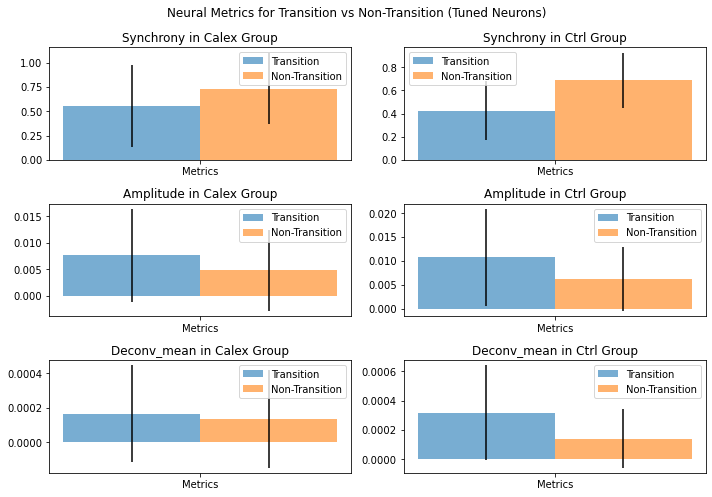

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def plot_group_results(data, neuron_type = 'open'):
      # Set this to match the analyzed neuron type
    metrics = ['synchrony', 'amplitude', 'deconv_mean']  # Adjusting metrics to include 'deconv_mean'
    groups = ['calex', 'ctrl']
    fig, axes = plt.subplots(3, 2, figsize=(10, 7))  # 3 metrics and 2 groups

    for metric_idx, metric in enumerate(metrics):
        for group_idx, group in enumerate(groups):
            ax = axes[metric_idx, group_idx]

            # Collect transition and non-transition data
            transition_data = [res[metric] for animal in data[group] if 'neural_analysis' in animal['analysis'] and neuron_type in animal['analysis']['neural_analysis'] for res in animal['analysis']['neural_analysis'][neuron_type]['transition'] if res[metric] is not None]
            non_transition_data = [res[metric] for animal in data[group] if 'neural_analysis' in animal['analysis'] and neuron_type in animal['analysis']['neural_analysis'] for res in animal['analysis']['neural_analysis'][neuron_type]['non_transition'] if res[metric] is not None]

            # Calculate means and standard deviations
            if transition_data and non_transition_data:
                transition_mean = np.nanmean(transition_data)
                non_transition_mean = np.nanmean(non_transition_data)
                transition_std = np.nanstd(transition_data)
                non_transition_std = np.nanstd(non_transition_data)

                # Define bar locations and widths
                bar_width = 0.35
                index = np.arange(1)  # Single set of bars

                # Plotting the bars
                ax.bar(index, transition_mean, bar_width, yerr=transition_std, label='Transition', alpha=0.6)
                ax.bar(index + bar_width, non_transition_mean, bar_width, yerr=non_transition_std, label='Non-Transition', alpha=0.6)

            # Setting labels and titles
            ax.set_title(f'{metric.capitalize()} in {group.capitalize()} Group')
            ax.set_xticks(index + bar_width / 2)
            ax.set_xticklabels(['Metrics'])
            ax.legend()

    plt.suptitle('Neural Metrics for Transition vs Non-Transition (Tuned Neurons)')
    plt.tight_layout()
    plt.show()

# Example call after analyzing data
plot_group_results(main_data, neuron_type = 'open')


### Overall Synchrony Comparison

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
from scipy.spatial.distance import squareform
from scipy.stats import zscore

def compute_clustered_corr_matrices(main_data, group, neuron_type='all'):
    clustered_matrices = []
    neuron_kinds = {
        'open': 1,
        'closed': 2,
        'unassigned': -2
    }

    for animal in main_data[group]:
        # Extract the signal matrix based on neuron type
        if neuron_type == 'all':
            data_matrix = animal['denoised']
        else:
            neuron_indices = animal['tuning_summary'][
                animal['tuning_summary']['Position'] == neuron_kinds[neuron_type]]['Neuron'].values
            if len(neuron_indices) == 0:
                continue
            data_matrix = animal['denoised'][:, neuron_indices]

        # Standardize the data (z-score)
        standardized_data = zscore(data_matrix, axis=0, nan_policy='omit')
        if np.any(np.isnan(standardized_data)) or standardized_data.size == 0:
            continue

        # Compute the correlation matrix
        if standardized_data.shape[1] == 1:
            corr_matrix = np.array([[1]])  # Correlation matrix for a single neuron
        else:
            corr_matrix = np.corrcoef(standardized_data, rowvar=False)

        # Handle cases where corr_matrix may be invalid due to poor data
        if np.isnan(corr_matrix).any() or corr_matrix.size == 0:
            continue

        # Reorder the matrix using hierarchical clustering
        ordered_corr_matrix = reorder_corr_matrix(corr_matrix)
        clustered_matrices.append(ordered_corr_matrix)

    return clustered_matrices

def reorder_corr_matrix(corr_matrix):
    """Reorder correlation matrix based on hierarchical clustering of neurons."""
    symmetric_corr_matrix = (corr_matrix + corr_matrix.T) / 2
    distance_matrix = 1 - symmetric_corr_matrix
    np.fill_diagonal(distance_matrix, 0)  # Ensure zero diagonal
    linkage_result = linkage(squareform(distance_matrix), method='average')
    leaf_order = leaves_list(linkage_result)
    ordered_corr_matrix = symmetric_corr_matrix[leaf_order][:, leaf_order]
    return ordered_corr_matrix

def compute_mean_correlation(correlation_matrices):
    """Compute the mean correlation value for each matrix and return the average of these means."""
    means = [np.mean(matrix[np.triu_indices_from(matrix, k=1)]) for matrix in correlation_matrices]
    return np.mean(means)

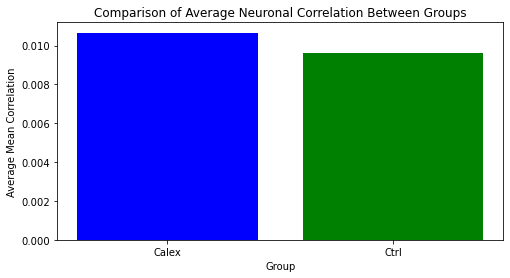

In [48]:
corr_matrices_ctrl = compute_clustered_corr_matrices(main_data, 'ctrl', 'all')
corr_matrices_calex = compute_clustered_corr_matrices(main_data, 'calex', 'all')

# Compute the average of mean correlations for each group
mean_corr_calex = compute_mean_correlation(corr_matrices_calex)
mean_corr_ctrl = compute_mean_correlation(corr_matrices_ctrl)

# Plotting the results
groups = ['Calex', 'Ctrl']
mean_correlations = [mean_corr_calex, mean_corr_ctrl]

plt.figure(figsize=(8, 4))
plt.bar(groups, mean_correlations, color=['blue', 'green'])
plt.xlabel('Group')
plt.ylabel('Average Mean Correlation')
plt.title('Comparison of Average Neuronal Correlation Between Groups')
#plt.ylim(0, 1)  # Assuming correlation values are between 0 and 1
plt.show()


In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

def find_representative_animals(corr_matrices_calex, corr_matrices_ctrl):
    """Identify the most representative animals from each group based on correlation matrices."""
    # Calculate mean correlation for each animal's matrix in each group
    means_calex = [np.mean(matrix[np.triu_indices_from(matrix, k=1)]) for matrix in corr_matrices_calex]
    means_ctrl = [np.mean(matrix[np.triu_indices_from(matrix, k=1)]) for matrix in corr_matrices_ctrl]

    # Calculate the overall mean for each group
    overall_mean_calex = np.mean(means_calex)
    overall_mean_ctrl = np.mean(means_ctrl)

    # Find the animal closest to the group mean in each group
    idx_calex = np.argmin([abs(m - overall_mean_calex) for m in means_calex])
    idx_ctrl = np.argmin([abs(m - overall_mean_ctrl) for m in means_ctrl])

    # Find the pair with the largest absolute difference in mean correlation
    max_diff = 0
    representative_calex = idx_calex
    representative_ctrl = idx_ctrl

    for i, m_calex in enumerate(means_calex):
        for j, m_ctrl in enumerate(means_ctrl):
            diff = abs(m_calex - m_ctrl)
            if diff > max_diff:
                max_diff = diff
                representative_calex = i
                representative_ctrl = j

    return representative_calex, representative_ctrl

# Use the function
representative_calex, representative_ctrl = find_representative_animals(corr_matrices_calex, corr_matrices_ctrl)
print("Representative Calex Animal Index:", representative_calex)
print("Representative Ctrl Animal Index:", representative_ctrl)

Representative Calex Animal Index: 1
Representative Ctrl Animal Index: 0


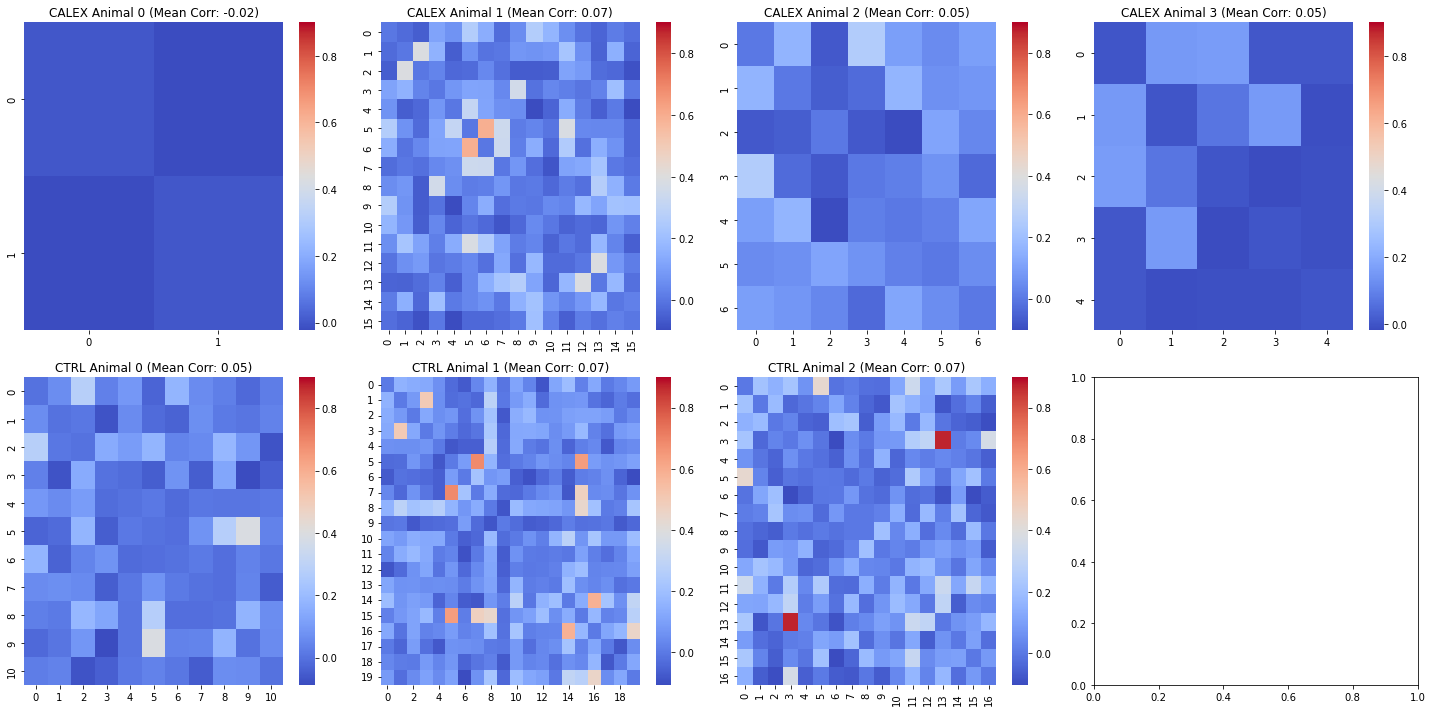

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import zscore

def calculate_correlation_matrices(main_data, group, neuron_type='closed'):
    correlation_matrices = []
    neuron_kinds = {
        'open': 1,
        'closed': 2,
        'unassigned': -2
    }

    for animal in main_data[group]:
        if neuron_type == 'all':
            data_matrix = animal['denoised']
        else:
            neuron_pos = neuron_kinds[neuron_type]
            data_matrix = animal['denoised'][:, animal['tuning_summary']['Position'] == neuron_pos]
            if data_matrix.shape[1] == 0:
                continue
        standardized_data = zscore(data_matrix, axis=0)
        if standardized_data.shape[1] < 2:
            continue  # Skip if there are less than 2 neurons
        corr_matrix = np.corrcoef(standardized_data, rowvar=False)
        correlation_matrices.append(corr_matrix)

    if len(correlation_matrices) == 0:
        raise ValueError(f"No valid correlation matrices found for group {group} and neuron type {neuron_type}")

    return correlation_matrices

def plot_individual_correlation_matrices(corr_matrices_calex, corr_matrices_ctrl, save_pdf=False, pdf_path='individual_animals_correlation_matrices.pdf'):
    """Plot correlation matrices for individual animals in each group."""
    num_calex = len(corr_matrices_calex)
    num_ctrl = len(corr_matrices_ctrl)

    # Create a figure with subplots for each animal
    fig, axes = plt.subplots(2, max(num_calex, num_ctrl), figsize=(20, 10))

    # Plot the correlation matrices for the calex group
    for i, corr_matrix in enumerate(corr_matrices_calex):
        np.fill_diagonal(corr_matrix, 0)
        mean_corr = np.mean(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
        sns.heatmap(corr_matrix, ax=axes[0, i], cmap='coolwarm', annot=False, vmax=0.9)
        axes[0, i].set_title(f'CALEX Animal {i} (Mean Corr: {mean_corr:.2f})')

    # Plot the correlation matrices for the ctrl group
    for i, corr_matrix in enumerate(corr_matrices_ctrl):
        np.fill_diagonal(corr_matrix, 0)
        mean_corr = np.mean(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
        sns.heatmap(corr_matrix, ax=axes[1, i], cmap='coolwarm', annot=False, vmax=0.9)
        axes[1, i].set_title(f'CTRL Animal {i} (Mean Corr: {mean_corr:.2f})')

    plt.tight_layout()

    if save_pdf:
        with PdfPages(pdf_path) as pdf:
            pdf.savefig(fig)
        print(f"PDF file saved to: {pdf_path}")
    else:
        plt.show()

    plt.close(fig)

# Assuming `main_data` is already defined and structured properly
corr_matrices_ctrl = calculate_correlation_matrices(main_data, 'ctrl', 'open')
corr_matrices_calex = calculate_correlation_matrices(main_data, 'calex', 'open')

# Plot individual correlation matrices
plot_individual_correlation_matrices(corr_matrices_calex, corr_matrices_ctrl, save_pdf=False, pdf_path='individual_animals_correlation_matrices_CaMKII_open.pdf')

print()

##### Visualize Synchrony

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform
from scipy.stats import zscore, ttest_ind, shapiro
from scipy.ndimage import zoom
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import scipy.stats as stats

def calculate_correlation_matrices(main_data, group, neuron_type='all'):
    correlation_matrices = []
    neuron_kinds = {
        'open': 1,
        'closed': 2,
        'unassigned': -2
    }

    for animal in main_data[group]:
        if neuron_type == 'all':
            data_matrix = animal['denoised']
        else:
            neuron_pos = neuron_kinds[neuron_type]
            data_matrix = animal['denoised'][:, animal['tuning_summary']['Position'] == neuron_pos]
            if data_matrix.shape[1] == 0:
                continue
        standardized_data = zscore(data_matrix, axis=0)
        if standardized_data.shape[1] < 2:
            continue  # Skip if there are less than 2 neurons
        corr_matrix = np.corrcoef(standardized_data, rowvar=False)
        if corr_matrix.shape[0] < 2:
            continue  # Skip if the correlation matrix is not 2D
        ordered_corr_matrix = reorder_matrix(corr_matrix)
        correlation_matrices.append(ordered_corr_matrix)

    if len(correlation_matrices) == 0:
        raise ValueError(f"No valid correlation matrices found for group {group} and neuron type {neuron_type}")

    mean_corr_matrix = average_matrices(correlation_matrices)
    return mean_corr_matrix

def reorder_matrix(corr_matrix):
    """Reorder correlation matrix based on hierarchical clustering of neurons."""
    if corr_matrix.ndim != 2 or corr_matrix.shape[0] != corr_matrix.shape[1]:
        raise ValueError("Correlation matrix must be a 2-dimensional square matrix")
    
    symmetric_corr_matrix = (corr_matrix + corr_matrix.T) / 2
    distance_matrix = 1 - symmetric_corr_matrix
    if distance_matrix.ndim < 2 or distance_matrix.shape[0] != distance_matrix.shape[1]:
        raise ValueError("Distance matrix must be a 2-dimensional square matrix")
    np.fill_diagonal(distance_matrix, 0)
    linkage_matrix = linkage(squareform(distance_matrix), method='average')
    dendro_order = leaves_list(linkage_matrix)
    ordered_corr_matrix = symmetric_corr_matrix[dendro_order][:, dendro_order]
    return ordered_corr_matrix

def average_matrices(matrices):
    max_size = 50
    resized_matrices = [resize_matrix(matrix, (max_size, max_size)) for matrix in matrices]
    return np.mean(resized_matrices, axis=0)

def resize_matrix(matrix, new_size):
    factors = np.array(new_size) / np.array(matrix.shape)
    return zoom(matrix, factors)


0.29418383449369884 0.3053117225230466
PDF file saved to: correlation_matrices_CaMKII.pdf
Shapiro-Wilk Test for CTRL: stat=0.8767529726028442, p-value=4.6336776080035486e-30
Shapiro-Wilk Test for CALEX: stat=0.8875739574432373, p-value=6.197917607908308e-29


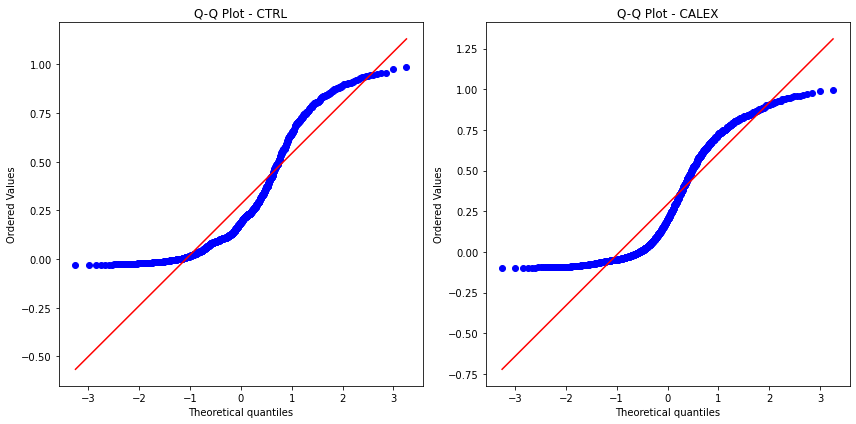

Data is not normally distributed. Consider using non-parametric tests.
Mean Matrices T-stat: 798745.0, P-value: 0.005667862600380848


In [57]:
def plot_and_save_correlation_matrices(mean_corr_matrix_ctrl, mean_corr_matrix_calex, save_pdf=False, pdf_path='correlation_matrices.pdf'):
    np.fill_diagonal(mean_corr_matrix_ctrl, 0)
    np.fill_diagonal(mean_corr_matrix_calex, 0)

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

    sns.heatmap(mean_corr_matrix_ctrl, ax=ax[0], cmap='coolwarm', annot=False, vmax=0.9)
    ax[0].set_title('Mean Correlation - CTRL')

    sns.heatmap(mean_corr_matrix_calex, ax=ax[1], cmap='coolwarm', annot=False, vmax=0.9)
    ax[1].set_title('Mean Correlation - CALEX')

    plt.tight_layout()

    if save_pdf:
        with PdfPages(pdf_path) as pdf:
            pdf.savefig(fig)
        print(f"PDF file saved to: {pdf_path}")
    else:
        plt.show()

    plt.close(fig)

def compare_matrices(matrix1, matrix2):
    if matrix1.shape != matrix2.shape:
        raise ValueError("Matrices must have the same shape for comparison")
    
    triu_indices = np.triu_indices_from(matrix1, k=1)
    values1 = matrix1[triu_indices]
    values2 = matrix2[triu_indices]
    
    # Check for normality
    stat1, p_value1 = shapiro(values1)
    stat2, p_value2 = shapiro(values2)
    print(f"Shapiro-Wilk Test for CTRL: stat={stat1}, p-value={p_value1}")
    print(f"Shapiro-Wilk Test for CALEX: stat={stat2}, p-value={p_value2}")
    
    # Plot Q-Q plots for visual inspection
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    stats.probplot(values1, dist="norm", plot=axes[0])
    axes[0].set_title('Q-Q Plot - CTRL')
    stats.probplot(values2, dist="norm", plot=axes[1])
    axes[1].set_title('Q-Q Plot - CALEX')
    plt.tight_layout()
    plt.show()
    
    if p_value1 > 0.05 and p_value2 > 0.05:
        print("Both groups are normally distributed. Proceeding with t-test.")
        t_stat, p_value = ttest_ind(values1, values2)
    else:
        print("Data is not normally distributed. Consider using non-parametric tests.")
        t_stat, p_value = stats.mannwhitneyu(values1, values2)
    
    return t_stat, p_value

# Assuming `main_data` is already defined and structured properly
mean_corr_matrix_ctrl = calculate_correlation_matrices(main_data, 'ctrl', 'closed')
mean_corr_matrix_calex = calculate_correlation_matrices(main_data, 'calex', 'closed')

print(mean_corr_matrix_ctrl.mean(), mean_corr_matrix_calex.mean())

plot_and_save_correlation_matrices(mean_corr_matrix_ctrl, mean_corr_matrix_calex, save_pdf=True, pdf_path='correlation_matrices_CaMKII.pdf')

# Perform statistical comparison
t_stat_mean, p_value_mean = compare_matrices(mean_corr_matrix_ctrl, mean_corr_matrix_calex)

print(f"Mean Matrices T-stat: {t_stat_mean}, P-value: {p_value_mean}")

##### Stats

In [53]:
import numpy as np
from scipy.stats import mannwhitneyu

def run_statistical_tests(data, neuron_type='open'):
    metrics = ['synchrony', 'amplitude', 'deconv_mean']  # Include 'deconv_mean'
    groups = ['calex', 'ctrl']
    
    for group in groups:
        print(f"Statistical Tests for {group.capitalize()} Group:")
        for metric in metrics:
            # Collect transition and non-transition data directly from main_data for a specific neuron type
            transition_data = [res[metric] for animal in data[group] if 'neural_analysis' in animal['analysis'] and neuron_type in animal['analysis']['neural_analysis'] for res in animal['analysis']['neural_analysis'][neuron_type]['transition'] if metric in res and res[metric] is not None]
            non_transition_data = [res[metric] for animal in data[group] if 'neural_analysis' in animal['analysis'] and neuron_type in animal['analysis']['neural_analysis'] for res in animal['analysis']['neural_analysis'][neuron_type]['non_transition'] if metric in res and res[metric] is not None]

            # Removing NaN values to prevent errors in statistical test
            transition_data = [x for x in transition_data if np.isfinite(x)]
            non_transition_data = [x for x in non_transition_data if np.isfinite(x)]

            if transition_data and non_transition_data:  # Ensure there is data to compare
                stat, p_value = mannwhitneyu(transition_data, non_transition_data, alternative='two-sided')
                print(f"{metric.capitalize()}: p-value = {p_value:.4f} (Transition vs. Non-Transition)")
            else:
                print(f"{metric.capitalize()}: Insufficient data for testing.")
        print("\n")

# Example call, assuming 'main_data' is correctly structured and filled
run_statistical_tests(main_data, 'open')  # Run tests for 'closed' type neurons


Statistical Tests for Calex Group:
Synchrony: p-value = 0.0000 (Transition vs. Non-Transition)
Amplitude: p-value = 0.0000 (Transition vs. Non-Transition)
Deconv_mean: p-value = 0.0195 (Transition vs. Non-Transition)


Statistical Tests for Ctrl Group:
Synchrony: p-value = 0.0000 (Transition vs. Non-Transition)
Amplitude: p-value = 0.0000 (Transition vs. Non-Transition)
Deconv_mean: p-value = 0.0000 (Transition vs. Non-Transition)




### Plot Selectively Tuned Neurons

In [54]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

def find_behavior_intervals(labels):
    """
    This function identifies the start and end points for each behavior interval.
    """
    starts = np.where(np.diff(labels, prepend=labels[0]-1) != 0)[0]
    ends = np.where(np.diff(labels, append=labels[-1]+1) != 0)[0]
    return list(zip(starts, ends, labels[starts]))

def plot_neuron_with_behaviors(title, time, neuron_data, labels, bx_select=1, save_to_pdf=False):
    """
    Plots the calcium trace for a single neuron and overlays behavior intervals.
    """
    fig, ax = plt.subplots(figsize=(15, 3))
    # Plot neuron calcium trace
    ax.plot(time, neuron_data, label='Neuron Calcium Trace', color='black')

    # Get behavior intervals
    intervals = find_behavior_intervals(labels)
    
    # Define colors for each behavior type (adjust numbers based on your actual behaviors)
    if bx_select == 1:
        colors = {0: 'red', 1: 'blue', 2: 'white', 3: 'yellow'}
    else:
        colors = {0: 'red', 1: 'white', 2: 'blue', 3: 'yellow'}
    bxlist = ["Open", "Closed"]
    # Overlay behavior intervals
    for start, end, behavior in intervals:
        ax.axvspan(time[start], time[end], color=colors[behavior], alpha=0.3, label=f'{bxlist[int(behavior)-1]}')
    
    # Making legend without duplicate labels
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Calcium Level')
    ax.set_title(title)
    
    if save_to_pdf:
        pdf_filename = f"{title.replace(' ', '_').replace(',', '')}.pdf"
        with PdfPages(pdf_filename) as pdf:
            pdf.savefig(fig)
        print(f"Plot saved as PDF file: {pdf_filename}")
    
    plt.show()

# Example usage

#### Find the top selectively tuned neurons for calex and ctlr

In [55]:
import pandas as pd

def find_top_group_tuned_neurons(data):
    groups = ['calex', 'ctrl']
    results = {}

    # Iterate over groups
    for group in groups:
        all_significant_neurons = []

        # Aggregate significant neurons across all animals in the group
        for animal_index, animal in enumerate(data[group]):
            tuning_summary = animal['tuning_summary']
            if not tuning_summary.empty:
                alpha = 0.05 / (tuning_summary.shape[0] * 2)  # Adjust for multiple testing across two behaviors
                # Gather all significant neurons for both behaviors
                for behavior in [1, 2]:
                    significant = tuning_summary[(tuning_summary[f'pvalue {behavior}'] < alpha)]
                    for _, row in significant.iterrows():
                        all_significant_neurons.append({
                            'animal_index': animal_index,
                            'neuron_index': int(row['Neuron']),
                            'AUC': row[f'AUC {behavior}'],
                            'behavior': behavior
                        })

        # Convert list of dicts to DataFrame
        df = pd.DataFrame(all_significant_neurons)

        # Find top 2 neurons tuned to each behavior
        top_neurons = []
        for behavior in [1, 2]:
            top_for_behavior = df[df['behavior'] == behavior].nlargest(2, 'AUC')
            top_neurons.extend(top_for_behavior.to_dict('records'))

        results[group] = pd.DataFrame(top_neurons)

    return results

# Example usage
top_neurons_results = find_top_group_tuned_neurons(main_data)
for group, df in top_neurons_results.items():
    print(f"Group: {group}\n", df)


Group: calex
    animal_index  neuron_index       AUC  behavior
0             1           254  0.869147         1
1             1            17  0.793363         1
2             1           103  0.765197         2
3             1           180  0.736539         2
Group: ctrl
    animal_index  neuron_index       AUC  behavior
0             2           111  0.739380         1
1             2            98  0.725722         1
2             0             9  0.698622         2
3             2           230  0.691471         2


#### Plot an example neuron with the corresponding behavior intervals

KeyError: -1.0

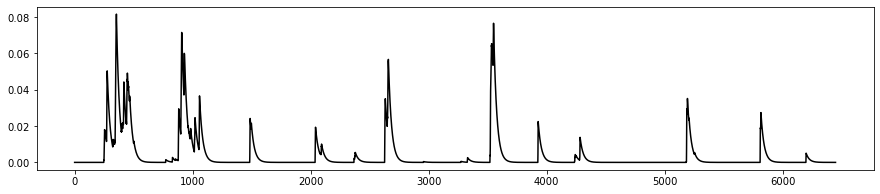

In [56]:
animal_index = 1
neuron_index = 104
ex_signal = main_data['calex'][animal_index]
time = np.arange(ex_signal['denoised'].shape[0])  # Assuming time steps are equal intervals
plot_neuron_with_behaviors(f'Ctrl Animal {animal_index}, Neuron {neuron_index}, Tuned', time, ex_signal['denoised'][:, neuron_index], ex_signal['bx_labels'], bx_select=1, save_to_pdf=True)    

In [ ]:
def analyze_selectively_tuned_neurons(data):
    for group, animals in data.items():
        for animal in animals:
            signal = animal['filt_denoised']  # Time x Neurons matrix filtered to remove -1 (undefined) time points
            labels = animal['filt_labels']  # Behavior labels filtered to remove -1 (undefined) time points
            tuning_summary = animal['tuning_summary']  # DataFrame with tuning data

            # Ensure the 'analysis' dictionary exists
            if 'analysis' not in animal:
                animal['analysis'] = {}
            
            # Initialize tuned signal analysis data storage
            animal['analysis']['tuned_signal_analysis'] = {'open': [], 'closed': []}

            # Select neurons that are selectively tuned to open (1) or closed (2)
            open_tuned_neurons = tuning_summary[tuning_summary['Position'] == 1]['Neuron'].values
            closed_tuned_neurons = tuning_summary[tuning_summary['Position'] == 2]['Neuron'].values

            # Calculate average signal during open and closed intervals for selectively tuned neurons
            for behavior, behavior_key in zip([1, 2], ['open', 'closed']):
                behavior_mask = labels == behavior
                tuned_neurons = open_tuned_neurons if behavior == 1 else closed_tuned_neurons
                if tuned_neurons.size > 0:
                    avg_signal = np.mean(signal[behavior_mask][:, tuned_neurons], axis=0)
                    animal['analysis']['tuned_signal_analysis'][behavior_key].extend(avg_signal.tolist())

# Example usage assuming main_data is already loaded and processed
analyze_selectively_tuned_neurons(main_data)


In [ ]:
#len(selective_neuron_results['calex']['open'])
len(main_data['calex'][0]['analysis']['tuned_signal_analysis']['open'])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

def plot_selective_neurons_results_seaborn(data):
    data_list = []
    groups = ['calex', 'ctrl']
    behaviors = ['open', 'closed']
    
    for group in groups:
        for animal in data[group]:
            if 'analysis' in animal and 'tuned_signal_analysis' in animal['analysis']:
                for behavior in behaviors:
                    for value in animal['analysis']['tuned_signal_analysis'][behavior]:
                        data_list.append({'Group': f'{group} {behavior}', 'Average Signal': value})

    data_frame = pd.DataFrame(data_list)

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    bar_plot = sns.barplot(x='Group', y='Average Signal', data=data_frame, palette="vlag")
    plt.title('Average Signal Strength of Tuned Neurons During Specific Behaviors')
    plt.ylabel('Average Signal Strength')
    plt.show()

# Now call this function with your data
plot_selective_neurons_results_seaborn(main_data)


In [ ]:
import numpy as np
from scipy.stats import mannwhitneyu

def run_group_comparison_tests(data):
    groups = ['calex', 'ctrl']
    conditions = ['open', 'closed']
    
    # Prepare to collect data for all conditions and groups
    condition_data = {group: {condition: [] for condition in conditions} for group in groups}
    
    # Collect data
    for group in groups:
        for animal in data[group]:
            if 'analysis' in animal and 'tuned_signal_analysis' in animal['analysis']:
                for condition in conditions:
                    condition_data[group][condition].extend(animal['analysis']['tuned_signal_analysis'][condition])

    # Perform comparisons within groups (open vs closed)
    for group in groups:
        open_data = condition_data[group]['open']
        closed_data = condition_data[group]['closed']
        stat, p_value = mannwhitneyu(open_data, closed_data, alternative='two-sided')
        print(f"{group.capitalize()} - Open vs Closed: p-value = {p_value:.4f}")

    # Perform comparisons across groups (calex vs ctrl for both open and closed)
    for condition in conditions:
        calex_data = condition_data['calex'][condition]
        ctrl_data = condition_data['ctrl'][condition]
        stat, p_value = mannwhitneyu(calex_data, ctrl_data, alternative='two-sided')
        print(f"Calex vs Ctrl - {condition.capitalize()}: p-value = {p_value:.4f}")

# Example call, assuming 'main_data' is correctly structured and filled
run_group_comparison_tests(main_data)


## Predict Transition vs Non-Transition from Time Series Right Before

In [ ]:
def make_training_data(main_data, group, pre_window, sampling_rate=30, buffer=2, neuron_type='all'):
    """Generates training data for transition prediction from neural activity, selecting neurons based on type."""
    transition_segments = []
    non_transition_segments = []
    labels = []  # 1 for transition, 0 for non-transition

    for animal in main_data[group]:
        signal = animal['denoised']
        labels_series = animal['filt_labels']
        tuning_summary = animal['tuning_summary']

        # Select neurons based on tuning type
        if neuron_type == 'open':
            neuron_indices = tuning_summary[tuning_summary['Position'] == 1]['Neuron'].values
        elif neuron_type == 'closed':
            neuron_indices = tuning_summary[tuning_summary['Position'] == 2]['Neuron'].values
        elif neuron_type == 'unassigned':
            neuron_indices = tuning_summary[tuning_summary['Position'] == -2]['Neuron'].values
        else:
            neuron_indices = np.arange(signal.shape[1])  # All neurons

        # Identify transition points with buffer
        transitions = np.where((labels_series[:-1] == 2) & (labels_series[1:] == 1))[0] + 1
        transitions = transitions[transitions >= (pre_window + buffer) * sampling_rate]  # Buffer after open exit

        # Extract transition segments ensuring buffer after open exit
        for idx in transitions:
            if np.all(labels_series[idx - pre_window * sampling_rate:idx] == 2) and \
               np.all(labels_series[idx - (pre_window + buffer) * sampling_rate:idx - pre_window * sampling_rate] != 1):
                segment = signal[idx - pre_window * sampling_rate:idx, neuron_indices]
                transition_segments.append(segment)
                labels.append(1)

        # Identifying stable closed segments for non-transitions
        closed_segments = np.where(labels_series == 2)[0]
        potential_starts = [idx for idx in closed_segments if idx >= (pre_window + buffer) * sampling_rate
                            and np.all(labels_series[idx - (pre_window + buffer) * sampling_rate:idx] == 2)]

        chosen_starts = np.random.choice(potential_starts, size=len(transition_segments), replace=False)

        # Extract non-transition segments with the same buffer
        for idx in chosen_starts:
            segment = signal[idx - pre_window * sampling_rate:idx, neuron_indices]
            non_transition_segments.append(segment)
            labels.append(0)

    # Combine and shuffle the segments and labels
    all_segments = transition_segments + non_transition_segments
    all_labels = np.array(labels)
    
    # Shuffle the data and labels
    indices = np.random.permutation(len(all_segments))
    shuffled_segments = [all_segments[i] for i in indices]
    shuffled_labels = all_labels[indices]

    return shuffled_segments, shuffled_labels


In [ ]:
def make_training_data(main_data, group, segment_length, sampling_rate=30, buffer=2, neuron_type='all'):
    """Generates training data for transition prediction from neural activity, selecting neurons based on type,
    with random shuffling at the end for generalization."""
    transition_segments = []
    non_transition_segments = []
    labels = []  # 1 for transition, 0 for non-transition

    for animal in main_data[group]:
        signal = animal['denoised']
        labels_series = animal['filt_labels']
        tuning_summary = animal['tuning_summary']

        # Define neuron indices based on type
        neuron_indices = get_neuron_indices(neuron_type, tuning_summary)
        if len(neuron_indices) == 0:
            continue

        # Extract closed intervals longer than 2*segment_length
        closed_indices = np.where(labels_series == 2)[0]
        if len(closed_indices) == 0:
            continue
        split_points = np.where(np.diff(closed_indices) != 1)[0] + 1
        closed_intervals = np.split(closed_indices, split_points)
        valid_intervals = [interval for interval in closed_intervals if len(interval) > 6 * segment_length * sampling_rate]

        for interval in valid_intervals:
            start_idx = interval[0] + buffer * sampling_rate
            end_idx = interval[-1] - (5*segment_length * sampling_rate + buffer * sampling_rate)
            
            # Extract non-transition segments
            non_trans_start = start_idx
            while (non_trans_start + segment_length * sampling_rate) <= end_idx:
                non_trans_end = non_trans_start + segment_length * sampling_rate
                segment = signal[non_trans_start:non_trans_end, neuron_indices]
                non_transition_segments.append(segment)
                labels.append(0)
                non_trans_start += segment_length * sampling_rate

            # Extract transition segment if there's a buffer at the end
            if interval[-1] < len(labels_series) - 1:
                trans_start = interval[-1] - segment_length * sampling_rate
                trans_end = interval[-1]
                segment = signal[trans_start:trans_end, neuron_indices]
                transition_segments.append(segment)
                labels.append(1)

    # Combine the segments and labels
    all_segments = transition_segments + non_transition_segments
    all_labels = np.array(labels)

    # Shuffle the data and labels to prevent order effects
    indices = np.random.permutation(len(all_segments))
    shuffled_segments = [all_segments[i] for i in indices]
    shuffled_labels = all_labels[indices]

    return shuffled_segments, shuffled_labels

def get_neuron_indices(neuron_type, tuning_summary):
    if neuron_type == 'all':
        return np.arange(tuning_summary.shape[0])
    return tuning_summary[tuning_summary['Position'] == {'open': 1, 'closed': 2, 'unassigned': -2}[neuron_type]]['Neuron'].values

In [ ]:
def make_training_data(main_data, group, segment_length, sampling_rate=30, buffer=2, neuron_type='all'):
    """Generates balanced training data for transition prediction from neural activity."""
    transition_segments = []
    non_transition_segments = []
    labels = []  # 1 for transition, 0 for non-transition

    for animal in main_data[group]:
        signal = animal['denoised']
        labels_series = animal['filt_labels']
        tuning_summary = animal['tuning_summary']

        # Define neuron indices based on type
        neuron_indices = get_neuron_indices(neuron_type, tuning_summary)
        if len(neuron_indices) == 0:
            continue

        # Extract closed intervals longer than 2*segment_length
        closed_indices = np.where(labels_series == 2)[0]
        if len(closed_indices) == 0:
            continue
        split_points = np.where(np.diff(closed_indices) != 1)[0] + 1
        closed_intervals = np.split(closed_indices, split_points)
        valid_intervals = [interval for interval in closed_intervals if len(interval) > 6 * segment_length * sampling_rate]

        for interval in valid_intervals:
            # Calculate middle start point for non-transition segment
            mid_point = len(interval) // 2
            start_idx = interval[mid_point] + buffer * sampling_rate - segment_length * sampling_rate // 2
            end_idx = start_idx + segment_length * sampling_rate

            # Extract middle non-transition segment if it is within bounds
            if start_idx >= interval[0] and end_idx <= interval[-1]:
                non_transition_segment = signal[start_idx:end_idx, neuron_indices]
                non_transition_segments.append(non_transition_segment)
                labels.append(0)

            # Extract transition segment if there's a buffer at the end
            if interval[-1] < len(labels_series) - 1:
                trans_start = interval[-1] - segment_length * sampling_rate
                trans_end = interval[-1]
                transition_segment = signal[trans_start:trans_end, neuron_indices]
                transition_segments.append(transition_segment)
                labels.append(1)

    # Combine the segments and labels
    all_segments = transition_segments + non_transition_segments
    all_labels = np.array(labels)

    # Shuffle the data and labels to prevent order effects
    indices = np.random.permutation(len(all_segments))
    shuffled_segments = [all_segments[i] for i in indices]
    shuffled_labels = all_labels[indices]

    return shuffled_segments, shuffled_labels

def get_neuron_indices(neuron_type, tuning_summary):
    if neuron_type == 'all':
        return np.arange(tuning_summary.shape[0])
    return tuning_summary[tuning_summary['Position'] == {'open': 1, 'closed': 2, 'unassigned': -2}[neuron_type]]['Neuron'].values


In [ ]:
def calculate_synchrony(segment):
    """Calculate the average off-diagonal correlation coefficient for a given window."""
    if segment.size == 0 or segment.shape[1] < 2:
        return 0  # Not enough neurons to calculate synchrony

    # Check for variance and remove columns (neurons) with zero variance if necessary
    variances = np.var(segment, axis=0)
    if np.all(variances == 0):
        return 0  # Return 0 if all neurons are inactive

    # Filter out neurons with zero variance to avoid NaNs in correlation calculation
    active_neurons = segment[:, variances > 0]
    if active_neurons.shape[1] < 2:
        return 0  # Not enough active neurons with non-zero variance to compute synchrony

    correlation_matrix = np.corrcoef(active_neurons.T)
    if np.isnan(correlation_matrix).any():
        print("NaN found in correlation matrix, likely due to insufficient data variability.")
        return 0

    np.fill_diagonal(correlation_matrix, 0)  # Ignore self-correlation
    synchrony = np.nanmean(correlation_matrix[np.triu_indices_from(correlation_matrix, k=1)])
    return synchrony


In [ ]:
def random_projection(segment, output_dim=5):
    """
    Project the segment matrix (T x N) onto a lower-dimensional space R using tensor contraction.

    Parameters:
    segment : array-like of shape (T, N)
        The input segment of neural activity data.
    R : int
        The dimension of the output vector after projection.

    Returns:
    projected_features : array-like of shape (R,)
        The resulting feature vector after tensor contraction.
    """
    T, N = segment.shape
    random_tensor = np.random.rand(T, N, output_dim)

    # Contract over the first two dimensions (T and N)
    # np.tensordot computes tensor dot product along specified axes
    projected_features = np.tensordot(segment, random_tensor, axes=([0, 1], [0, 1]))

    return projected_features

In [ ]:
def calculate_derivatives(segment):
    """ Calculate the first and second derivatives of the signal and return their overall mean values. """
    if segment.size == 0:
        return 0, 0

    # Compute first derivative along the time axis
    first_derivative = np.diff(segment, axis=0)
    # Compute second derivative from the first derivative
    second_derivative = np.diff(first_derivative, axis=0)

    # Calculate the mean of the derivatives across all neurons and all time points
    mean_first_derivative = np.mean(first_derivative)
    mean_second_derivative = np.mean(second_derivative)

    return mean_first_derivative, mean_second_derivative

def extract_features(segment):
    if segment.size == 0:
        return None

    # Basic statistics
    mean_signal = np.mean(segment)
    variance_signal = np.var(segment)
    max_signal = np.max(segment)
    mean_sum = np.mean(np.sum(segment, axis=0))
    synchrony = calculate_synchrony(segment)

    # Derivatives
    mean_first_derivative, mean_second_derivative = calculate_derivatives(segment)
    # Random projection
    random_projection_features = random_projection(segment, output_dim=6)
    # Split the segment into two halves
    halfway_point = segment.shape[0] // 2
    first_half = segment[:halfway_point, :]
    second_half = segment[halfway_point:, :]

    # Compute first half features
    mean_first_half = np.mean(first_half)
    variance_first_half = np.var(first_half)
    max_first_half = np.max(first_half)
    mean_sum_first_half = np.mean(np.sum(first_half, axis=0))
    synchrony_first_half = calculate_synchrony(first_half)

    # Compute second half features
    mean_second_half = np.mean(second_half)
    variance_second_half = np.var(second_half)
    max_second_half = np.max(second_half)
    mean_sum_second_half = np.mean(np.sum(second_half, axis=0))
    synchrony_second_half = calculate_synchrony(second_half)

    # Compute changes between halves
    change_mean = mean_second_half - mean_first_half
    change_variance = variance_second_half - variance_first_half
    change_max = max_second_half - max_first_half
    change_mean_sum = mean_sum_second_half - mean_sum_first_half
    change_synchrony = synchrony_second_half - synchrony_first_half
    # Combine all features into a single vector
    features = np.array([
        mean_signal, variance_signal, max_signal, mean_sum, synchrony,
         mean_first_derivative, mean_second_derivative,
        change_mean, change_variance, change_max, change_mean_sum, change_synchrony,
    ])
    features = np.concatenate((features, random_projection_features))

    return features

In [ ]:
def prepare_features(segments):
    """Prepare features by extracting from each segment and handling cases where extraction fails."""
    feature_list = []
    valid_labels = []  # List to store labels corresponding to valid segments

    for i, segment in enumerate(segments):
        try:
            features = extract_features(segment)
            if features is not None:
                feature_list.append(features)
                valid_labels.append(labels[i])  # Append label only if features are valid
        except Exception as e:
            # Log or print the exception if something goes wrong
            print(f"Failed to extract features from segment {i}: {e}")

    return feature_list, valid_labels

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import KMeansSMOTE
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN

def train_random_forest(features, labels, feature_names=None, n_estimators=100, max_depth=None, n_splits=10, random_state=None, plot_importance=False):
    """
    Trains a Random Forest classifier using cross-validation and reports feature importance along with several evaluation metrics.
    
    The function now handles lists by converting them to numpy arrays.
    """
    # Convert lists to numpy arrays if necessary
    features = np.array(features)
    labels = np.array(labels)
    
    if features.ndim == 1:
        features = features.reshape(-1, 1)  # Reshape if features is a 1D array to avoid issues in scikit-learn
    
    if len(features) != len(labels):
        raise ValueError("Mismatch in the number of features and labels")

    # Creating the Random Forest model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)

    # Initialize metrics storage
    cv_accuracy = []
    cv_precision = []
    cv_recall = []
    cv_f1 = []
    cv_auc = []
    all_importances = []
    
    # Set up cross-validation
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Perform cross-validation
    for train_index, test_index in kf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        # Apply SMOTE only to the training data
        #rebalancer = SMOTE(random_state=7)
        #rebalancer = ADASYN(sampling_strategy='auto', random_state=7)
        #X_train, y_train = rebalancer.fit_resample(X_train, y_train)
        #print(np.unique(y_train, return_counts=True))
        # Fit the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]  # probabilities for positive class
        
        # Calculate metrics
        cv_accuracy.append(model.score(X_test, y_test))
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        cv_precision.append(precision)
        cv_recall.append(recall)
        cv_f1.append(f1)
        cv_auc.append(roc_auc_score(y_test, y_prob))
        all_importances.append(model.feature_importances_)
    
    # Average feature importances across folds
    average_importances = np.mean(all_importances, axis=0)
    
    # Plot feature importances if required
    if plot_importance and feature_names:
        indices = np.argsort(average_importances)[::-1]
        plt.figure(figsize=(10, 6))
        plt.title('Feature Importances')
        plt.bar(range(len(feature_names)), average_importances[indices], color='b', align='center')
        plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=90)
        plt.xlabel('Feature Index')
        plt.ylabel('Relative Importance')
        plt.show()
    
    # Compile results
    return {
        'model': model,
        'cross_val_accuracy': cv_accuracy,
        'cross_val_precision': np.mean(cv_precision),
        'cross_val_recall': np.mean(cv_recall),
        'cross_val_f1': np.mean(cv_f1),
        'cross_val_auc': np.mean(cv_auc),
        'feature_importances': average_importances
    }

# Now you can use this function, assuming your features and labels are ready for training.
# Example usage:
# results = train_random_forest(features, labels, feature_names=feature_names, n_estimators=100, max_depth=10, random_state=42, plot_importance=True)
# print(results)


In [ ]:
feature_names = [
    "mean_signal", "variance_signal", "max_signal", "mean_sum", "synchrony",
    "mean_first_derivative", "mean_second_derivative",
    "change_mean", "change_variance", "change_max", "change_mean_sum", "change_synchrony", 
    "rp_0", "rp_1", "rp_2", "rp_3",
    "rp_4", 
    "rp_5"
]

In [ ]:
# CTRL:
segments, labels = make_training_data(main_data, 'ctrl', 1, 15, neuron_type='closed')  # Ensure segments are created correctly
print(len(segments), len(labels))
ctrl_features, ctrl_labels = prepare_features(segments)
print(len(ctrl_labels), len(ctrl_features))
results_ctrl = train_random_forest(ctrl_features, ctrl_labels, feature_names=feature_names, plot_importance=True)
print("Cross-Validated Accuracy:", np.mean(results_ctrl['cross_val_accuracy']))
print(f"Cross-Validated Precision: {results_ctrl['cross_val_precision']:.4f}")
print(f"Cross-Validated Recall: {results_ctrl['cross_val_recall']:.4f}")
print(f"Cross-Validated F1-Score: {results_ctrl['cross_val_f1']:.4f}")
print(f"Cross-Validated AUC: {results_ctrl['cross_val_auc']:.4f}")

In [ ]:
# CALEX
segments, labels = make_training_data(main_data, 'calex', 1, 15, neuron_type='closed')  # Ensure segments are created correctly
print(len(segments), len(labels))
calex_features, calex_labels = prepare_features(segments)
print(len(calex_labels), len(calex_features))
results_calex = train_random_forest(calex_features, calex_labels, feature_names=feature_names, plot_importance=True)
print("Cross-Validated Accuracy:", np.mean(results_calex['cross_val_accuracy']))
print(f"Cross-Validated Precision: {results_calex['cross_val_precision']:.4f}")
print(f"Cross-Validated Recall: {results_calex['cross_val_recall']:.4f}")
print(f"Cross-Validated F1-Score: {results_calex['cross_val_f1']:.4f}")
print(f"Cross-Validated AUC: {results_calex['cross_val_auc']:.4f}")

#### The max signal was identified as a differentiating feature between transition and non-transition

In [ ]:
from scipy.stats import mannwhitneyu
import numpy as np
import pandas as pd

"""
mean_signal, variance_signal, max_signal, 
mean_sum, synchrony, mean_first_derivative, 
mean_second_derivative, change_mean, change_variance, 
change_max, change_mean_sum, change_synchrony,
"""
ind = 4
ctrl_max_signals = np.array(ctrl_features)[:, ind]
calex_max_signals = np.array(calex_features)[:, ind]

# Create DataFrames
df_ctrl = pd.DataFrame({
    'Max Signal': ctrl_max_signals,
    'Condition': ctrl_labels,
    'Group': 'Ctrl'
})
df_calex = pd.DataFrame({
    'Max Signal': calex_max_signals,
    'Condition': calex_labels,
    'Group': 'Calex'
})

ctrl_trans_max = df_ctrl[df_ctrl['Condition'] == 1]['Max Signal']
calex_trans_max = df_calex[df_calex['Condition'] == 1]['Max Signal']
ctrl_nontrans_max = df_ctrl[df_ctrl['Condition'] == 0]['Max Signal']
calex_nontrans_max = df_calex[df_calex['Condition'] == 0]['Max Signal']

# Perform the Mann-Whitney U Test for within-group transitions vs non-transitions
u_stat, p_value = mannwhitneyu(ctrl_trans_max, ctrl_nontrans_max, alternative='two-sided')
print(f"Ctrl Trans vs Ctrl NonTrans P-value: {p_value}")

u_stat, p_value = mannwhitneyu(calex_trans_max, calex_nontrans_max, alternative='two-sided')
print(f"Calex Trans vs Calex NonTrans P-value: {p_value}")

# Perform the Mann-Whitney U Test for cross-group comparisons of the same condition
u_stat, p_value = mannwhitneyu(ctrl_trans_max, calex_trans_max, alternative='two-sided')
print(f"Ctrl Trans vs Calex Trans P-value: {p_value}")

u_stat, p_value = mannwhitneyu(ctrl_nontrans_max, calex_nontrans_max, alternative='two-sided')
print(f"Ctrl NonTrans vs Calex NonTrans P-value: {p_value}")

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_max_signals(ctrl_features, ctrl_labels, calex_features, calex_labels):
    # Assuming index 2 is max_signal
    ind = 2
    ctrl_max_signals = np.array(ctrl_features)[:, ind]
    calex_max_signals = np.array(calex_features)[:, ind]

    # Create DataFrames
    df_ctrl = pd.DataFrame({
        'Max Signal': ctrl_max_signals,
        'Condition': ctrl_labels,
        'Group': 'Ctrl'
    })
    df_calex = pd.DataFrame({
        'Max Signal': calex_max_signals,
        'Condition': calex_labels,
        'Group': 'Calex'
    })

    # Convert labels to a more descriptive form
    df_ctrl['Condition'] = df_ctrl['Condition'].map({0: 'Non-Transition', 1: 'Transition'})
    df_calex['Condition'] = df_calex['Condition'].map({0: 'Non-Transition', 1: 'Transition'})

    # Concatenate both DataFrames
    df_combined = pd.concat([df_ctrl, df_calex])

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Group', y='Max Signal', hue='Condition', data=df_combined, whis=1.5, showfliers=False)
    plt.title('Max Signal for Transition vs Non-Transition Across Groups')
    plt.legend(title='Condition')
    plt.tight_layout()
    #plt.savefig("max_signal_transition_decoding.pdf")
    plt.show()

# Example call to the function
# Ensure ctrl_features, ctrl_labels, calex_features, and calex_labels are correctly prepared
plot_max_signals(ctrl_features, ctrl_labels, calex_features, calex_labels)


In [ ]:
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(results_ctrl['cross_val_accuracy'], results_calex['cross_val_accuracy'], alternative='two-sided')

print(f"Mann-Whitney U test statistic: {stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference between the distributions of cross-validation accuracies.")
else:
    print("There is no statistically significant difference between the distributions of cross-validation accuracies.")


__Cross-validated accuracy__ is a robust measure used to evaluate how well a predictive model performs across different subsets of data. In cross-validation, the data set is divided into several smaller parts or "folds." The model is then trained on all but one of these folds and tested on the remaining fold to measure accuracy. This process is repeated such that each fold serves as the test set once, ensuring that the model's performance is assessed on every part of the data. The final cross-validated accuracy is the average of these individual accuracies. This method helps to prevent overfitting, which occurs when a model performs well on the training data but poorly on unseen data, and provides a more generalizable estimate of model performance in real-world scenarios. 

##### Compare to Null Distribution of Training Data with Shuffled Labels

In [ ]:
from sklearn.utils import shuffle
import numpy as np

# CTRL:
segments, labels = make_training_data(main_data, 'ctrl', 1, 15, neuron_type='closed')  # Ensure segments are created correctly
features, labels = prepare_features(segments)
shuffled_labels = shuffle(labels, random_state=7)

results_ctrl_null = train_random_forest(features, shuffled_labels, feature_names=feature_names, plot_importance=False)

print("Null Distribution Training Data Results:")
print("Cross-Validated Accuracy:", np.mean(results_ctrl_null['cross_val_accuracy']))
print(f"Cross-Validated Precision: {results_ctrl_null['cross_val_precision']:.4f}")
print(f"Cross-Validated Recall: {results_ctrl_null['cross_val_recall']:.4f}")
print(f"Cross-Validated F1-Score: {results_ctrl_null['cross_val_f1']:.4f}")
print(f"Cross-Validated AUC: {results_ctrl_null['cross_val_auc']:.4f}")

### Compare Ctrl to Null Distribution

In [ ]:
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(results_ctrl['cross_val_accuracy'], results_ctrl_null['cross_val_accuracy'], alternative='two-sided')

print(f"Mann-Whitney U test statistic: {stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference between the distributions of cross-validation accuracies.")
else:
    print("There is no statistically significant difference between the distributions of cross-validation accuracies.")

### Compare CalEx to Null

In [ ]:
from sklearn.utils import shuffle
import numpy as np

# CALEX:
segments, labels = make_training_data(main_data, 'calex', 1, 15, neuron_type='closed')  # Ensure segments are created correctly
features, labels = prepare_features(segments)
shuffled_labels = shuffle(labels, random_state=7)

results_calex_null = train_random_forest(features, shuffled_labels, feature_names=feature_names, plot_importance=False)
print("Cross-Validated Accuracy of Null Calex: ", np.mean(results_calex_null['cross_val_accuracy']))
#
stat, p_value = mannwhitneyu(results_calex['cross_val_accuracy'], results_calex_null['cross_val_accuracy'], alternative='two-sided')

print(f"Mann-Whitney U test statistic: {stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference between the distributions of cross-validation accuracies.")
else:
    print("There is no statistically significant difference between the distributions of cross-validation accuracies.")

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_cross_val_accuracies_seaborn(title, results_calex, results_ctrl, results_calex_null, results_ctrl_null, save=True):
    # Prepare data for plotting
    data = {
        'Calex': results_calex['cross_val_accuracy'],
        'Calex \n Shuffled': results_calex_null['cross_val_accuracy'],
        'Ctrl': results_ctrl['cross_val_accuracy'],
        'Ctrl \n Shuffled': results_ctrl_null['cross_val_accuracy']
    }
    # Create DataFrame for seaborn plotting
    df = pd.DataFrame(data)
    df_long = df.melt(var_name='Group', value_name='Accuracy')
    
    # Create the boxplot
    plt.figure(figsize=(4, 6))
    sns.boxplot(x='Group', y='Accuracy', data=df_long, palette=["lightblue", "lightgray", "lightgreen", "lightgray"], whis=1.5)

    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel(None)
    sns.despine(trim=True)  # Removes the top and right spines for a cleaner look
    if save:
        plt.savefig(f"{title}.pdf", format='pdf')
    plt.show()
    
    #plt.close() 

In [ ]:

# Call the function with your data
plot_cross_val_accuracies_seaborn('Decoding Closed-Open Transitions', results_calex, results_ctrl, results_calex_null, results_ctrl_null)


# Predict Open vs Closed Arm

In [ ]:
import numpy as np

def create_training_data_open_vs_closed(data, group, segment_length=15, buffer=10, neuron_type='all'):
    segments = []
    labels = []
    
    for animal in data[group]:
        signal = animal['filt_denoised']
        labels_series = animal['filt_labels']
        tuning_summary = animal['tuning_summary']

        # Define neuron indices based on type
        neuron_indices = np.arange(signal.shape[1])  # Default to 'all' neurons
        if neuron_type == 'open':
            neuron_indices = tuning_summary[tuning_summary['Position'] == 1]['Neuron'].values
        elif neuron_type == 'closed':
            neuron_indices = tuning_summary[tuning_summary['Position'] == 2]['Neuron'].values
        elif neuron_type == 'unassigned':
            neuron_indices = tuning_summary[tuning_summary['Position'] == -2]['Neuron'].values
        
        if neuron_indices.size == 0:
            print(f"No neurons of type '{neuron_type}' found for animal in group '{group}'.")
            continue

        # Identify intervals
        for behavior in [1, 2]:  # 1 for open, 2 for closed
            behavior_indices = np.where(labels_series == behavior)[0]
            if behavior_indices.size == 0:
                print(f"No behavior indices for '{behavior}' found.")
                continue

            # Split indices into continuous intervals
            splits = np.where(np.diff(behavior_indices) != 1)[0] + 1
            intervals = np.split(behavior_indices, splits)

            # Process each interval
            for interval in intervals:
                interval_length = len(interval)
                if interval_length > segment_length + 2 * buffer:
                    start_index = interval[0] + buffer
                    end_index = interval[-1] - buffer - segment_length + 1  # Adjust end_index to allow full segment

                    for start in range(start_index, end_index, segment_length):
                        if start + segment_length <= interval[-1] - buffer:  # Ensure segment is within bounds
                            segment = signal[start:start + segment_length, neuron_indices]
                            if segment.size == 0:
                                print(f"Segment is empty or too small, skipped. Interval length: {len(interval)}")
                                continue
                            segments.append(segment)
                            labels.append(1 if behavior == 1 else 0)
                        else:
                            print(f"Segment starting at {start} out of bounds for interval ending at {interval[-1] - buffer}.")

    # Shuffle segments and labels to mix open and closed segments
    if segments:
        indices = np.random.permutation(len(segments))
        shuffled_segments = [segments[i] for i in indices]
        shuffled_labels = np.array([labels[i] for i in indices])
        return shuffled_segments, shuffled_labels
    else:
        print("No valid segments were created.")
        return [], []



##### CTRL

In [ ]:
# CTRL:
segments, labels = create_training_data_open_vs_closed(main_data, 'ctrl', segment_length=30, buffer=15, neuron_type='closed')
print(len(segments), len(labels))
features, labels = prepare_features(segments)  # Assuming 'prepare_features' is already defined
print(len(features), len(labels))
results_ctrl = train_random_forest(features, labels, feature_names=feature_names, plot_importance=True)
print("Cross-Validated Accuracy:", np.mean(results_ctrl['cross_val_accuracy']))
print(f"Cross-Validated Precision: {results_ctrl['cross_val_precision']:.4f}")
print(f"Cross-Validated Recall: {results_ctrl['cross_val_recall']:.4f}")
print(f"Cross-Validated F1-Score: {results_ctrl['cross_val_f1']:.4f}")
print(f"Cross-Validated AUC: {results_ctrl['cross_val_auc']:.4f}")

##### CalEx

In [ ]:
# CTRL:
segments, labels = create_training_data_open_vs_closed(main_data, 'calex', segment_length=30, buffer=15, neuron_type='closed')
print(len(segments), len(labels))
features, labels = prepare_features(segments)  # Assuming 'prepare_features' is already defined
print(len(features), len(labels))
results_calex = train_random_forest(features, labels, feature_names=feature_names, plot_importance=True)
print("Cross-Validated Accuracy:", np.mean(results_calex['cross_val_accuracy']))
print(f"Cross-Validated Precision: {results_calex['cross_val_precision']:.4f}")
print(f"Cross-Validated Recall: {results_calex['cross_val_recall']:.4f}")
print(f"Cross-Validated F1-Score: {results_calex['cross_val_f1']:.4f}")
print(f"Cross-Validated AUC: {results_calex['cross_val_auc']:.4f}")

##### Compare Ctrl to Null Distribution of Training Data with Shuffled Labels

In [ ]:
from sklearn.utils import shuffle
import numpy as np

# Null Distribution:
segments, labels = create_training_data_open_vs_closed(main_data, 'ctrl', segment_length=30, buffer=15, neuron_type='closed')
features, labels = prepare_features(segments)
shuffled_labels = shuffle(labels, random_state=7)

results_ctrl_null = train_random_forest(features, shuffled_labels, feature_names=feature_names, plot_importance=False)

print("Null Distribution Training Data Results:")
print("Cross-Validated Accuracy:", np.mean(results_ctrl_null['cross_val_accuracy']))
print(f"Cross-Validated Precision: {results_ctrl_null['cross_val_precision']:.4f}")
print(f"Cross-Validated Recall: {results_ctrl_null['cross_val_recall']:.4f}")
print(f"Cross-Validated F1-Score: {results_ctrl_null['cross_val_f1']:.4f}")
print(f"Cross-Validated AUC: {results_ctrl_null['cross_val_auc']:.4f}")

In [ ]:
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(results_ctrl['cross_val_accuracy'], results_ctrl_null['cross_val_accuracy'], alternative='two-sided')

print(f"Mann-Whitney U test statistic: {stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference between the distributions of cross-validation accuracies.")
else:
    print("There is no statistically significant difference between the distributions of cross-validation accuracies.")

##### Compare Calex to Null Distribution of Training Data with Shuffled Labels

In [ ]:
from sklearn.utils import shuffle
import numpy as np

# Null Distribution:
segments, labels = create_training_data_open_vs_closed(main_data, 'calex', segment_length=30, buffer=15, neuron_type='closed')
features, labels = prepare_features(segments)
shuffled_labels = shuffle(labels, random_state=7)

results_calex_null = train_random_forest(features, shuffled_labels, feature_names=feature_names, plot_importance=False)

print("Null Distribution Training Data Results:")
print("Cross-Validated Accuracy:", np.mean(results_calex_null['cross_val_accuracy']))
print(f"Cross-Validated Precision: {results_calex_null['cross_val_precision']:.4f}")
print(f"Cross-Validated Recall: {results_calex_null['cross_val_recall']:.4f}")
print(f"Cross-Validated F1-Score: {results_calex_null['cross_val_f1']:.4f}")
print(f"Cross-Validated AUC: {results_calex_null['cross_val_auc']:.4f}")

In [ ]:
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(results_calex['cross_val_accuracy'], results_calex_null['cross_val_accuracy'], alternative='two-sided')

print(f"Mann-Whitney U test statistic: {stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference between the distributions of cross-validation accuracies.")
else:
    print("There is no statistically significant difference between the distributions of cross-validation accuracies.")

In [ ]:
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(results_calex['cross_val_accuracy'], results_ctrl['cross_val_accuracy'], alternative='two-sided')

print(f"Mann-Whitney U test statistic: {stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference between the distributions of cross-validation accuracies.")
else:
    print("There is no statistically significant difference between the distributions of cross-validation accuracies.")

In [ ]:
plot_cross_val_accuracies_seaborn("Decoding Position", results_calex, results_ctrl, results_calex_null, results_ctrl_null)

# Predict if a Neuron is from the Ctrl or Calex Group (TODO)

# Export Results to Excel

In [ ]:
%%time
def export_analysis_to_excel(main_data, file_name):
    """Export analysis data from main_data to an Excel file with multiple sheets."""
    with pd.ExcelWriter(file_name, engine='openpyxl') as writer:
        # Process each group and their animals
        for group in ['calex', 'ctrl']:
            # Compile neural_analysis data
            neural_data = []
            for animal_index, animal in enumerate(main_data[group]):
                if 'neural_analysis' in animal['analysis']:
                    for neuron_type in ['open', 'closed', 'unassigned', 'all']:
                        if neuron_type in animal['analysis']['neural_analysis']:
                            for condition in ['transition', 'non_transition']:
                                for data_point in animal['analysis']['neural_analysis'][neuron_type][condition]:
                                    neural_data.append({
                                        'Group': group,
                                        'Animal': animal_index + 1,
                                        'Neuron Type': neuron_type,
                                        'Condition': condition,
                                        'Synchrony': data_point['synchrony'],
                                        'Amplitude': data_point['amplitude'],
                                        'Deconv Mean': data_point['deconv_mean']
                                    })
            if neural_data:
                df_neural = pd.DataFrame(neural_data)
                df_neural.to_excel(writer, sheet_name=f'{group}_neural_analysis', index=False)

            # Compile tuned_signal_analysis data
            signal_data = []
            for animal_index, animal in enumerate(main_data[group]):
                if 'tuned_signal_analysis' in animal['analysis']:
                    for behavior in ['open', 'closed']:
                        for signal_index, signal_strength in enumerate(animal['analysis']['tuned_signal_analysis'][behavior]):
                            signal_data.append({
                                'Group': group,
                                'Animal': animal_index + 1,
                                'Neuron ID': signal_index + 1,
                                'Neuron Type': behavior,
                                'Mean Amplitude': signal_strength
                            })
            if signal_data:
                df_signal = pd.DataFrame(signal_data)
                df_signal.to_excel(writer, sheet_name=f'{group}_tuned_signal_analysis', index=False)

    print(f"Exported analysis to {file_name}")

# Assuming your main_data is structured with the required analysis data
file_name = 'analysis_results_refactor.xlsx'
export_analysis_to_excel(main_data, file_name)

In [ ]:
#main_data['calex'][0]['analysis']['tuned_signal_analysis']

### Things that didn't work
1. Predicting transition from pre-window, only got 64% accuracy with one group or into the 70s% if we combine calex/ctrl data.
2. Relationship Between Neuronal Synchrony and Time Spent in Open Arm 
3. Average Amplitude vs Normalized Open Interval Length Before Open Intervals (no clear relationship)
4. Spike Frequency vs Normalized Open Interval Length Before Open Intervals (both grps show positive correlation between spike freq and open interval length)
5. Average Neuronal Synchrony by Group and Behavior (means look different (calex closed lower than calex open, same for ctrl, and ctrl overall higher than calex in both conditions; not statistically sig since only 5 pts per condition)
6. Comparison of Average Synchrony vs. Spike Frequency (weak negative correlation between synchrony and spike frequency for calex, even weaker/non sig positive correlation)
7. Relationship Between Neuronal Synchrony and Open Arm Entries (very weak negative correlation)
8. Comparison of Spike Frequencies (no significant difference between calex and ctrl on average)
9. There is no statistically significant difference between the distributions of mean neuron activities for calex and ctrl groups. But there was a trend toward calex haver higher mean activity.

In [ ]:
def explore_keys(data, indent=0):
    """Recursively explore and print keys from a nested dictionary structure."""
    if isinstance(data, dict):
        for key in data.keys():
            print(' ' * indent + str(key))
            explore_keys(data[key], indent + 2)
    elif isinstance(data, list):
        print(' ' * indent + f"List of {len(data)} items")
        if data:
            explore_keys(data[0], indent + 2)  # Explore the first item if the list is not empty

# Example usage, assuming main_data is structured properly
for group in main_data.keys():
    print(group)
    for animal in main_data[group]:
        explore_keys(animal, 2)  # Start with an indentation level of 2 for better readability
        break
    break

# Frame-by-Frame Decoding

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report

In [ ]:
# Assuming X is your Time x Neurons matrix and y is your 1D array
j = 1
X = main_data['ctrl'][j]['filt_denoised']
y = main_data['ctrl'][j]['filt_labels']

In [ ]:
def uniform_sampling_split(n_samples, sample_interval=1, frame_rate=30):
    """
    Generate indices for training and testing sets by sampling training data uniformly every `sample_interval` seconds.
    The rest of the data is used as the test set.

    Parameters:
    - n_samples: Total number of samples in the dataset.
    - sample_interval: Interval in seconds at which to sample training frames.
    - frame_rate: Number of frames per second.

    Returns:
    - train_indices: Indices of samples selected for training.
    - test_indices: Indices of samples selected for testing.
    """
    # Calculate the number of frames to skip to achieve the desired sampling interval
    skip_frames = sample_interval * frame_rate
    
    # Generate training indices by sampling every `skip_frames` frames
    train_indices = np.arange(0, n_samples, skip_frames)
    
    # All other indices are used for testing
    test_indices = np.setdiff1d(np.arange(n_samples), train_indices)

    return train_indices, test_indices
    
def rolling_window_cross_val(n_samples, sample_interval=1, frame_rate=30, n_folds=5):
    """
    Generate train/test datasets using a rolling window on uniformly sampled training points.

    Parameters:
    - n_samples: Total number of samples in the dataset.
    - sample_interval: Interval in seconds to sample training frames.
    - frame_rate: Number of frames per second.
    - n_folds: Number of folds for the cross-validation.

    Yields:
    - train_indices: Indices of the training set for the current fold.
    - test_indices: Indices of the testing set for the current fold.
    """
    base_train_indices, full_test_indices = uniform_sampling_split(n_samples, sample_interval, frame_rate)
    total_train_samples = len(base_train_indices)

    # Determine fold size based on the number of available training indices
    fold_size = total_train_samples // n_folds
    
    for i in range(n_folds):
        # Calculate start and end indices of the test segment within the train indices array
        test_start = i * fold_size
        test_end = test_start + fold_size if i < n_folds - 1 else total_train_samples
        
        # Split the base_train_indices into current fold's training and testing indices
        fold_test_indices = base_train_indices[test_start:test_end]
        fold_train_indices = np.concatenate([base_train_indices[:test_start], base_train_indices[test_end:]])
        
        # Convert these indices into actual data indices in the original dataset
        fold_train_data_indices = np.setdiff1d(base_train_indices, fold_test_indices)
        fold_test_data_indices = np.union1d(fold_test_indices, full_test_indices)
        
        yield fold_train_data_indices, fold_test_data_indices

In [ ]:
def plot_with_behavior_intervals(ax, data, y_true, y_pred, title, behavior_label):
    # Plot FLD Component Trace
    line, = ax.plot(data[:, 0], label='FLD Component Trace', color='black', alpha=0.9)
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Projection Amplitude')

    # Determine the maximum y value to adjust ylim later
    max_y = max(data[:, 0])

    # Function to plot intervals for true or predicted behaviors
    def plot_intervals(y, color, label, ymin, ymax, alpha=0.3):
        start = None
        for i in range(len(y) + 1):  # go one past the end for final check
            if i < len(y) and y[i] == behavior_label and start is None:
                start = i  # start of new interval
            elif start is not None and (i == len(y) or y[i] != behavior_label):
                # end of interval or end of data
                ax.axvspan(start, i, color=color, alpha=alpha, ymin=ymin, ymax=ymax, label=label)
                label = "_nolegend_"  # avoid duplicate labels in legend
                start = None  # reset start

    # Plot true behavior intervals slightly lower to leave space for predicted intervals
    plot_intervals(y_true, 'lightblue', 'True Intervals', 0, 0.9, 0.7)

    # Plot predicted behavior intervals slightly higher with a gap
    plot_intervals(y_pred, 'darkblue', 'Predicted Interval', 0.91, 1)

    # Adjust ylim to ensure there's space above the highest spike
    ax.set_ylim(min(data[:, 0]), max_y * 1.1)  # Increase max_y by 10%

    # Creating custom legend
    true_patch = mpatches.Patch(color='lightblue', alpha=0.2, label='True Intervals')
    pred_patch = mpatches.Patch(color='darkblue', alpha=0.2, label='Predicted Interval')
    ax.legend(handles=[line, true_patch, pred_patch])

In [ ]:
def process_dataset(X, y, n_splits=5, test_size=0.2):
    n_samples = X.shape[0]
    accs = []
    rocs = []
    tt = 0
    for train_index, test_index in rolling_window_cross_val(n_samples, sample_interval=1, frame_rate=30, n_folds=50):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Apply FLD only on the training data
        X1 = X_train[y_train == 1]
        X2 = X_train[y_train == 2]

        # Compute means and scatter matrices for the training data
        mu1 = np.mean(X1, axis=0)
        mu2 = np.mean(X2, axis=0)
        S1 = np.dot((X1 - mu1).T, (X1 - mu1))
        S2 = np.dot((X2 - mu2).T, (X2 - mu2))
        Sw = S1 + S2
        mean_difference = np.atleast_2d(mu1 - mu2).T
        Sb = np.dot(mean_difference, mean_difference.T)

        # Regularization and solving the eigenvalue problem
        regularization_term = 0.00001 * np.eye(Sw.shape[0])
        Sw += regularization_term
        eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
        eigenvectors = np.real(eigenvectors)

        # Sort and project
        sorted_indices = np.argsort(eigenvalues)[::-1]
        w = eigenvectors[:, sorted_indices[:2]]
        Y_train = X_train.dot(w)
        Y_test = X_test.dot(w)
        # Train the classifier
        clf = LogisticRegression(class_weight='balanced')
        clf.fit(Y_train, y_train)
        # auROC
        y_probs = clf.predict_proba(Y_test)[:, 1]  # Probabilities for the positive class (usually class '1')
        # Calculate ROC AUC
        roc_auc = roc_auc_score(y_test, y_probs)
        rocs.append(roc_auc)
        # Predict and evaluate
        y_pred = clf.predict(Y_test)
        accs.append(accuracy_score(y_test, y_pred))
        # Plotting - show only one example fold
        if tt == 2:
            fig, axs = plt.subplots(1, 1, figsize=(12, 4))
            # -1 to ensure "spikes" are pointing up
            plot_with_behavior_intervals(axs, -1 * Y_test, y_test, y_pred, "Calcium Trace Projection onto FLD", 1)
            fig2, axs2 = plt.subplots(1, 2, figsize=(12, 4))
            axs2[0].set_title("Training Data FLD Projection")
            axs2[0].scatter(Y_train[y_train == 1, 0], Y_train[y_train == 1, 1], color='blue', label='Open Arm', alpha=0.5)
            axs2[0].scatter(Y_train[y_train == 2, 0], Y_train[y_train == 2, 1], color='red', label='Closed Arm', alpha=0.5)
            axs2[0].axvline(0, color='black', linestyle='dotted', alpha=0.5, linewidth=4)
            #
            axs2[1].set_title("Test Data FLD Projection")
            axs2[1].scatter(Y_test[y_test == 1, 0], Y_test[y_test == 1, 1], color='blue', label='Open Arm', alpha=0.5)
            axs2[1].scatter(Y_test[y_test == 2, 0], Y_test[y_test == 2, 1], color='red', label='Closed Arm', alpha=0.5)
            axs2[1].axvline(0, color='black', linestyle='dotted', alpha=0.5, linewidth=4)
        tt+=1
    return accs, rocs

In [ ]:
# True data
accs, rocs = process_dataset(X, y, n_splits=10, test_size=0.1)
print(np.mean(accs),np.mean(rocs))

In [ ]:
def block_shuffle(data, block_size=10):
    """
    Shuffle data by dividing it into blocks of `block_size` and then randomly shuffling these blocks.
    Accommodates any data length by treating the remaining elements as an additional block if needed.
    
    Parameters:
        data (np.array): The original data array.
        block_size (int): The size of each block to be shuffled.
    
    Returns:
        np.array: The block shuffled data.
    """
    # Determine the number of full blocks and the remainder
    n_blocks = len(data) // block_size
    remainder = len(data) % block_size
    
    # Create an array of block indices for full blocks
    blocks = np.arange(n_blocks)
    # Shuffle the block indices
    np.random.shuffle(blocks)
    
    # Create an empty array to hold the shuffled data
    shuffled_data = np.zeros_like(data)
    
    # Fill the shuffled_data array with shuffled full blocks
    for i, block_idx in enumerate(blocks):
        start_idx = block_idx * block_size
        shuffled_data[i * block_size:(i + 1) * block_size] = data[start_idx:start_idx + block_size]
    
    # Handle the remainder by appending it to the end of the shuffled data
    if remainder > 0:
        remainder_start = n_blocks * block_size
        shuffled_data[-remainder:] = data[remainder_start:remainder_start + remainder]
    
    return shuffled_data

##### Using shuffled (randomized) frame labels (null hypothesis)

In [ ]:
# Shuffled label data as control/comparator
accs_rand, rocs_rand = process_dataset(X, block_shuffle(y), n_splits=10, test_size=0.1)
print(np.mean(accs_rand),np.mean(rocs_rand))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu

def plot_results(accs, accs_rand, rocs, rocs_rand):
    """
    Plots boxplots for accuracies and ROC AUC values for true and randomized labels.
    Also performs Mann-Whitney U tests to determine statistical significance between groups.
    
    Parameters:
    - accs: List of accuracies from true labels
    - accs_rand: List of accuracies from randomized labels
    - rocs: List of ROC AUC values from true labels
    - rocs_rand: List of ROC AUC values from randomized labels
    """
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    
    # Accuracy boxplots
    axs[0].boxplot([accs, accs_rand], labels=['True Labels', 'Randomized Labels'])
    axs[0].set_title('Comparison of Accuracies')
    axs[0].set_ylabel('Accuracy')

    # ROC AUC boxplots
    axs[1].boxplot([rocs, rocs_rand], labels=['True Labels', 'Randomized Labels'])
    axs[1].set_title('Comparison of ROC AUCs')
    axs[1].set_ylabel('ROC AUC')
    
    plt.show()
    
    # Statistical tests
    acc_stat, acc_p = mannwhitneyu(accs, accs_rand, alternative='greater')
    roc_stat, roc_p = mannwhitneyu(rocs, rocs_rand, alternative='greater')
    
    print("Accuracy - Mann-Whitney U test: U = {}, p-value = {}".format(acc_stat, acc_p))
    print("ROC AUC - Mann-Whitney U test: U = {}, p-value = {}".format(roc_stat, roc_p))

    if acc_p < 0.05:
        print("The difference in accuracy between true and randomized labels is statistically significant.")
    else:
        print("No significant difference in accuracy between true and randomized labels.")
        
    if roc_p < 0.05:
        print("The difference in ROC AUC between true and randomized labels is statistically significant.")
    else:
        print("No significant difference in ROC AUC between true and randomized labels.")

# Example usage (assuming you have already computed accs, accs_rand, rocs, rocs_rand):
# plot_results(accs, accs_rand, rocs, rocs_rand)


In [ ]:
plot_results(accs, accs_rand, rocs, rocs_rand)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

def plot_results_violin(accs, accs_rand, rocs, rocs_rand):
    """
    Plots violin plots for accuracies and ROC AUC values for true and randomized labels.
    Also performs Mann-Whitney U tests to determine statistical significance between groups.
    """
    # Prepare the data for the DataFrame
    data = {
        'Value': accs + accs_rand + rocs + rocs_rand,
        'Metric': ['Accuracy']*len(accs) + ['Accuracy']*len(accs_rand) + 
                  ['ROC AUC']*len(rocs) + ['ROC AUC']*len(rocs_rand),
        'Label': ['True']*len(accs) + ['Random']*len(accs_rand) + 
                 ['True']*len(rocs) + ['Random']*len(rocs_rand)
    }
    
    df = pd.DataFrame(data)

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    sns.violinplot(x='Metric', y='Value', hue='Label', data=df[df['Metric'] == 'Accuracy'], split=False, inner='quart', ax=axs[0])
    sns.violinplot(x='Metric', y='Value', hue='Label', data=df[df['Metric'] == 'ROC AUC'], split=False, inner='quart', ax=axs[1])

    axs[0].set_title('Comparison of Accuracies')
    axs[1].set_title('Comparison of ROC AUCs')
    plt.legend()
    plt.show()
    
    # Statistical tests
    acc_stat, acc_p = mannwhitneyu(df[(df['Metric'] == 'Accuracy') & (df['Label'] == 'True')]['Value'],
                                   df[(df['Metric'] == 'Accuracy') & (df['Label'] == 'Random')]['Value'], 
                                   alternative='greater')
    roc_stat, roc_p = mannwhitneyu(df[(df['Metric'] == 'ROC AUC') & (df['Label'] == 'True')]['Value'],
                                   df[(df['Metric'] == 'ROC AUC') & (df['Label'] == 'Random')]['Value'], 
                                   alternative='greater')
    
    print("Accuracy - Mann-Whitney U test: U = {}, p-value = {}".format(acc_stat, acc_p))
    print("ROC AUC - Mann-Whitney U test: U = {}, p-value = {}".format(roc_stat, roc_p))

    if acc_p < 0.05:
        print("The difference in accuracy between true and randomized labels is statistically significant.")
    else:
        print("No significant difference in accuracy between true and randomized labels.")
        
    if roc_p < 0.05:
        print("The difference in ROC AUC between true and randomized labels is statistically significant.")
    else:
        print("No significant difference in ROC AUC between true and randomized labels.")

# Assuming the data are ready and the function is called as such:
# plot_results_violin(accs, accs_rand, rocs, rocs_rand)


In [ ]:
plot_results_violin(accs, accs_rand, rocs, rocs_rand)

# Archive

In [ ]:
Changing tasks here for a bit.

Consider this function:
```python
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

def process_dataset(X, y, plot=False, show_print=False):
    # Split the data based on class labels
    X1 = X[y == 1]  # Data from open arm
    X2 = X[y == 2]  # Data from closed arm

    # Compute the means of each class
    mu1 = np.mean(X1, axis=0)
    mu2 = np.mean(X2, axis=0)

    # Compute the within-class scatter matrices
    S1 = np.dot((X1 - mu1).T, (X1 - mu1))
    S2 = np.dot((X2 - mu2).T, (X2 - mu2))
    Sw = S1 + S2  # Within-class scatter matrix

    # Compute the between-class scatter matrix
    mean_difference = np.atleast_2d(mu1 - mu2).T
    Sb = np.dot(mean_difference, mean_difference.T)

    regularization_term = 0.00001 * np.eye(Sw.shape[0])  # Adjust this value as needed
    Sw += regularization_term

    # Solve the eigenvalue problem
    eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
    eigenvectors = np.real(eigenvectors)  # Taking the real part

    # Sort and project
    sorted_indices = np.argsort(eigenvalues)[::-1]
    w = eigenvectors[:, sorted_indices[:2]]
    Y = X.dot(w)
    if plot:
        # Visualization to verify the separability
        plt.figure(figsize=(8, 6))
        plt.scatter(Y[y == 1, 0], Y[y == 1, 1], label='Open Arm', alpha=0.5)
        plt.scatter(Y[y == 2, 0], Y[y == 2, 1], label='Closed Arm', alpha=0.5)
        plt.title('Projection of Calcium Imaging Data using FLD')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Splitting the data - typically, 70% training and 30% testing
    X_train, X_test, y_train, y_test = train_test_split(Y, y, test_size=0.3, random_state=42)

    # Initialize the classifier
    clf = LogisticRegression(class_weight='balanced')

    # Train the classifier on the training data
    clf.fit(X_train, y_train)

    # Predict the labels for the test set
    y_pred = clf.predict(X_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    

    # Optionally, show the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    

    # Use cross-validation to assess the robustness of the model
    scores = cross_val_score(clf, Y, y, cv=5)  # cv=5 for 5-fold cross-validation
    if show_print:
        print("Accuracy:", accuracy)
        print("Confusion Matrix:\n", conf_matrix)
        print("Cross-validated accuracy scores:", scores)
        print("Mean CV accuracy:", np.mean(scores))
    return scores

# Example usage with multiple datasets:
# datasets = [(X1, y1), (X2, y2), ...]
# for X, y in datasets:
#     process_dataset(X, y)
```

I want to use this function on all the animals in `main_data` and save the FLD data and analysis results under a subkey, like `main_data['calex'][0]['FLD']`  and then save the cross-validation scores under `main_data['calex'][0]['FLD']['fld_cross_val_scores']` and the FLD matrix `main_data['calex'][0]['FLD']['fld_matrix']` and using the logistic 

I also 

In [ ]:
def process_dataset(X, y):
    # Splitting the data first
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply FLD only on the training data
    X1 = X_train[y_train == 1]
    X2 = X_train[y_train == 2]

    # Compute means and scatter matrices for the training data
    mu1 = np.mean(X1, axis=0)
    mu2 = np.mean(X2, axis=0)
    S1 = np.dot((X1 - mu1).T, (X1 - mu1))
    S2 = np.dot((X2 - mu2).T, (X2 - mu2))
    Sw = S1 + S2
    mean_difference = np.atleast_2d(mu1 - mu2).T
    Sb = np.dot(mean_difference, mean_difference.T)

    # Regularization and solving the eigenvalue problem
    regularization_term = 0.00001 * np.eye(Sw.shape[0])
    Sw += regularization_term
    eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
    eigenvectors = np.real(eigenvectors)

    # Sort and project
    sorted_indices = np.argsort(eigenvalues)[::-1]
    w = eigenvectors[:, sorted_indices[:2]]
    Y_train = X_train.dot(w)
    Y_test = X_test.dot(w)  # Transform test set using the same projection
    print(Y_train.shape)
    # Train the classifier
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(Y_train, y_train)

    # Predict and evaluate
    y_pred = clf.predict(Y_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", conf_matrix)

    # Cross-validation using the transformed entire dataset
    Y = np.vstack((Y_train, Y_test))
    cross_y = np.hstack((y_train, y_test))
    scores = cross_val_score(clf, Y, cross_y, cv=5)  # cv=5 for 5-fold cross-validation
    print("Cross-validated accuracy scores:", scores)
    print("Mean CV accuracy:", np.mean(scores))
    #
    print("Precision:", precision_score(y_test, y_pred, average='binary', pos_label=1))
    print("Recall:", recall_score(y_test, y_pred, average='binary', pos_label=1))
    print("\nFull Classification Report:\n")
    print(classification_report(y_test, y_pred))

    # Optionally, visualize the projected training data
    fig, ax = plt.subplots(3,1)
    fig.set_size_inches(8, 12)
    ax[0].scatter(Y_train[y_train == 1, 0], Y_train[y_train == 1, 1], label='Open Arm', alpha=0.5)
    ax[0].scatter(Y_train[y_train == 2, 0], Y_train[y_train == 2, 1], label='Closed Arm', alpha=0.5)
    ax[0].set_title('Projection of Training Data using FLD')
    ax[0].set_xlabel('Component 1')
    ax[0].set_ylabel('Component 2')
    ax[0].legend()
    ax[0].grid(True)
    #
    ax[1].set_title("Projection of Test Data using FLD")
    ax[1].scatter(Y_test[y_test == 1, 0], Y_test[y_test == 1, 1], label='Open Arm', alpha=0.5)
    ax[1].scatter(Y_test[y_test == 2, 0], Y_test[y_test == 2, 1], label='Closed Arm', alpha=0.5)
    #
    ax[2].set_title("Projection of Calcium Trace onto Comp 1")
    # Shows a kind of "mean" trace projected onto FLD component 1, with shaded areas showing behavior 1
    # Code here
    ax[3].set_title("Projection of Calcium Trace onto Comp 2")
    # Shows a kind of "mean" trace projected onto FLD component 2, with shaded areas showing behavior 2
    # Code here

# Example of using this function with your data:
# process_dataset(X, y)


In [ ]:

def process_dataset(X, y):
    # Divide the time series into 100 contiguous segments
    segment_length = len(X) // 10
    segments = [i * segment_length for i in range(100)] + [len(X)]
    
    # Use every 1th segment for testing, the rest for training
    test_indices = [np.random.randint(0,10)]
    train_indices = np.setdiff1d(np.arange(10), test_indices)

    # Extracting train and test segments
    train_mask = np.hstack([np.arange(segments[i], segments[i+1]) for i in train_indices])
    test_mask = np.hstack([np.arange(segments[i], segments[i+1]) for i in test_indices])
    
    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[test_mask], y[test_mask]
    print(100.0 * y_test.shape[0] / y_train.shape[0])
    # Shuffle within each group
    X_train, y_train = shuffle(X_train, y_train, random_state=42)
    X_test, y_test = shuffle(X_test, y_test, random_state=42)
    # FLD calculation, using a manual approach to ensure full control over the matrix
    X1 = X_train[y_train == 1]
    X2 = X_train[y_train == 2]

    mu1 = np.mean(X1, axis=0)
    mu2 = np.mean(X2, axis=0)
    S1 = np.dot((X1 - mu1).T, (X1 - mu1))
    S2 = np.dot((X2 - mu2).T, (X2 - mu2))
    Sw = S1 + S2
    mean_difference = np.atleast_2d(mu1 - mu2).T
    Sb = np.dot(mean_difference, mean_difference.T)

    regularization_term = 0.00001 * np.eye(Sw.shape[0])
    Sw += regularization_term
    eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
    eigenvectors = np.real(eigenvectors)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    w = eigenvectors[:, sorted_indices[:2]]
    
    Y_train = X_train.dot(w)
    Y_test = X_test.dot(w)

    clf = LogisticRegression(class_weight='balanced')
    clf.fit(Y_train, y_train)
    y_pred = clf.predict(Y_test)
    
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='binary', pos_label=1))
    print("Recall:", recall_score(y_test, y_pred, average='binary', pos_label=1))
    print("\nFull Classification Report:\n", classification_report(y_test, y_pred))
    # Obtain probabilities for the positive class
    y_probs = clf.predict_proba(Y_test)[:, 1]  # Probabilities for the positive class (usually class '1')

    # Calculate ROC AUC
    roc_auc = roc_auc_score(y_test, y_probs)
    print("auROC:", roc_auc)

    # Plotting
    fig, ax = plt.subplots(4, 1, figsize=(10, 20))

    # Train projection
    ax[0].scatter(Y_train[y_train == 1, 0], Y_train[y_train == 1, 1], color='blue', label='Open Arm', alpha=0.5)
    ax[0].scatter(Y_train[y_train == 2, 0], Y_train[y_train == 2, 1], color='red', label='Closed Arm', alpha=0.5)
    ax[0].set_title('Projection of Training Data using FLD')
    ax[0].set_xlabel('Component 1')
    ax[0].set_ylabel('Component 2')
    ax[0].legend()
    ax[0].grid(True)

    # Test projection
    ax[1].scatter(Y_test[y_test == 1, 0], Y_test[y_test == 1, 1], color='blue', label='Open Arm', alpha=0.5)
    ax[1].scatter(Y_test[y_test == 2, 0], Y_test[y_test == 2, 1], color='red', label='Closed Arm', alpha=0.5)
    ax[1].set_title('Projection of Test Data using FLD')
    ax[1].set_xlabel('Component 1')
    ax[1].set_ylabel('Component 2')
    ax[1].legend()
    ax[1].grid(True)

    # Projection of Calcium Trace onto Component 1
    Y_full = X.dot(w[:, 0])
    ax[2].plot(Y_full, color='black', label='FLD Component 1 Projection')
    ax[2].set_title('Projection of Calcium Trace onto Component 1')
    ax[2].set_xlabel('Time')
    ax[2].set_ylabel('Amplitude')
    ax[2].grid(True)
    #for t in np.where(y == 1)[0]:
    #    ax[2].axvspan(t, t+1, color='blue', alpha=0.5)  # Assuming each point is a single time unit

    # Projection of Calcium Trace onto Component 2
    Y_full = X.dot(w[:, 1])
    ax[3].plot(Y_full, color='black', label='FLD Component 2 Projection')
    ax[3].set_title('Projection of Calcium Trace onto Component 2')
    ax[3].set_xlabel('Time')
    ax[3].set_ylabel('Amplitude')
    ax[3].grid(True)
    #for t in np.where(y == 2)[0]:
    #    ax[3].axvspan(t, t+1, color='red', alpha=0.5)  # Assuming each point is a single time unit

    plt.tight_layout()
    plt.show()

# Example of using this function with your data:
# process_dataset(X, y)


In [ ]:

def plot_with_behavior_intervals(ax, data, y, title, comp):
    data = data[:, comp-1]
    ax.plot(data, label='FLD Component Trace')
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Projection Amplitude')

    # Efficient behavior interval plotting
    last = None
    for i, (label, sample) in enumerate(zip(y, data)):
        if label != last:
            if last is not None:
                ax.axvspan(start, i, color='red' if last == 1 else 'blue', alpha=0.2 if last == comp else 0)
            start = i
        last = label
    if last is not None:
        ax.axvspan(start, len(data), color='red' if last == 1 else 'blue', alpha=0.2 if last == comp else 0)

    ax.legend()